In [504]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [505]:
# Set the display format for floating-point numbers
pd.options.display.float_format = '{:.2f}'.format

In [506]:
file_1 = "C:/Users/Efrem/Downloads/meesho_statement_2/DICE Challenge Business Analytics Case 2/clicks__data.csv"
file_2 = "C:/Users/Efrem/Downloads/meesho_statement_2/DICE Challenge Business Analytics Case 2/views__data.csv"
file_3 = "C:/Users/Efrem/Downloads/meesho_statement_2/DICE Challenge Business Analytics Case 2/orders__table.csv"

In [507]:
click_data = pd.read_csv(file_1)
view_data = pd.read_csv(file_2)
order_data = pd.read_csv(file_3)

In [508]:
data = order_data.copy()
data['clicks_count'] = click_data['clicks_count']
data['app_open_count'] = view_data['app_open_count']
data['order_date'] = pd.to_datetime(data['order_date'])
sample = data.copy()
data

,order_id,order_date,user_id,order_value,category,quantity,order_status,supplier_id,feedback,clicks_count,app_open_count
0,0,2023-09-26,14225,4044.37,Home Goods,1,cancelled,565,Negative feedback,1,4
1,1,2024-09-08,19369,2969.24,Clothing,10,cancelled,222,Positive feedback,11,46
2,2,2024-03-08,339,4985.45,Electronics,2,cancelled,907,Neutral feedback,44,48
3,3,2023-11-26,19310,4328.57,Clothing,4,delivered,176,Neutral feedback,37,42
4,4,2023-11-20,13523,2517.05,Home Goods,1,delivered,207,Negative feedback,10,19
...,...,...,...,...,...,...,...,...,...,...,...
999995,999995,2023-10-04,11904,896.17,Home Goods,9,cancelled,769,Negative feedback,16,35
999996,999996,2023-12-14,83686,828.17,Clothing,5,returned,968,Positive feedback,7,27
999997,999997,2024-07-09,37213,4156.44,Electronics,6,delivered,745,Neutral feedback,6,7
999998,999998,2024-08-17,99950,4931.21,Home Goods,6,exchanged,423,Negative feedback,5,8


In [509]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   order_id        1000000 non-null  int64         
 1   order_date      1000000 non-null  datetime64[ns]
 2   user_id         1000000 non-null  int64         
 3   order_value     1000000 non-null  float64       
 4   category        1000000 non-null  object        
 5   quantity        1000000 non-null  int64         
 6   order_status    1000000 non-null  object        
 7   supplier_id     1000000 non-null  int64         
 8   feedback        1000000 non-null  object        
 9   clicks_count    1000000 non-null  int64         
 10  app_open_count  1000000 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(3)
memory usage: 83.9+ MB


In [510]:
max_date = data['order_date'].max()
min_date = data['order_date'].min()
unique_customers = data['user_id'].nunique()
unique_suppliers = data['supplier_id'].nunique()
total_orders = data['order_id'].nunique()
total_quantity = data['quantity'].sum()
total_sales = data['order_value'].sum()

print(f"Date Range : {min_date} to {max_date}")
print(f"Total number of Customers : {unique_customers}")
print(f"Total number of Suppliers : {unique_suppliers}")
print(f"Total number of Orders : {total_orders}")
print(f"Total number of Quantity Sold : {total_quantity}")
print(f"Total Sales : {total_sales}")

Date Range : 2023-09-12 00:00:00 to 2024-09-10 00:00:00
Total number of Customers : 99989
Total number of Suppliers : 1000
Total number of Orders : 1000000
Total number of Quantity Sold : 5500335
Total Sales : 2500132333.99


In [511]:
# Function to calculate RFM
def calculate_rfm(df, customer_id_col, order_id_col, order_date_col, order_value_col, snapshot_date=None):
    """
    Calculate RFM (Recency, Frequency, and Monetary) values for customers.

    Parameters:
    df (pd.DataFrame): DataFrame containing customer data.
    customer_id_col (str): The column name for the customer ID.
    order_date_col (str): The column name for the order date.
    order_value_col (str): The column name for the order value.
    snapshot_date (str or datetime, optional): The date to calculate recency against (default is today).

    Returns:
    pd.DataFrame: DataFrame with customer_id, Recency, Frequency, and Monetary values.
    """

    # Set the snapshot date (for recency calculation), default is today if not provided
    if snapshot_date is None:
        snapshot_date = datetime.today()
    else:
        snapshot_date = pd.to_datetime(snapshot_date)
    
    # Ensure the order_date_col is in datetime format
    df[order_date_col] = pd.to_datetime(df[order_date_col])
    
    # Ensure that only delivered / exchanged orders are accounted for monetary calculation
    filtered_df = df[df['order_status'].isin(['delivered', 'exchanged'])]
    filtered_df = filtered_df.groupby(customer_id_col).agg({order_value_col : 'sum'}).reset_index()

    # Calculate Recency: difference between the snapshot date and the last order date
    rfm_df = df.groupby(customer_id_col).agg({
        order_date_col: lambda x: (snapshot_date - x.max()).days,  # Recency
        order_id_col: 'count',  # Frequency
    }).reset_index()
    
    # Merging the DataFrames on 'user_id'
    merged_df = pd.merge(rfm_df, filtered_df, on=customer_id_col, how='left')

    # Replacing NaN values with 0
    merged_df[order_value_col] = merged_df[order_value_col].fillna(0)

    # Rename columns to Recency, Frequency, and Monetary
    merged_df.columns = [customer_id_col, 'Recency', 'Frequency', 'Monetary']

    return merged_df

In [512]:
# Function to map feedback and calculate the weighted feedback score
def calculate_feedback(df, customer_id_col, feedback_col, feedback_date_col, today, recent_threshold=30, alpha=0.7, beta=0.3):
    """
    Function to map feedback to a numerical score and calculate weighted feedback based on recency.
    
    Parameters:
    df (pd.DataFrame): The input dataframe with feedback data.
    customer_id_col (str): The column name for the customer ID.
    feedback_col (str): Column name for feedback (positive/negative/neutral).
    feedback_date_col (str): Column name for feedback date.
    today (str): The last date / latest date wrt which the recency will be calculated.
    recent_threshold (int): Number of days to classify feedback as 'recent'. Default is 30 days.
    alpha (float): Weight for recent feedback. Default is 0.7.
    beta (float): Weight for older feedback. Default is 0.3.
    
    Returns:
    pd.DataFrame: DataFrame with the weighted feedback scores.
    """

    # Step 1: Map the feedback to numerical scores
    feedback_mapping = {
        'Positive feedback': 1,
        'Neutral feedback': 0,
        'Negative feedback': -1
    }
    df['feedback_mapped'] = df[feedback_col].map(feedback_mapping)
    
    # Convert feedback_date_col to datetime if not already
    df[feedback_date_col] = pd.to_datetime(df[feedback_date_col])
    
    # Step 2: Calculate days since feedback was provided
    if not today :
        today = pd.to_datetime("today")
    df['days_since_feedback'] = (today - df[feedback_date_col]).dt.days
    
    # Step 3: Classify feedback as 'recent' or 'older'
    df['feedback_type'] = df['days_since_feedback'].apply(lambda x: 'recent' if x <= recent_threshold else 'older')
    
    # Step 4: Calculate the weighted feedback score based on recency
    df['weighted_feedback'] = df.apply(lambda x: alpha * x['feedback_mapped'] if x['feedback_type'] == 'recent' 
                                       else beta * x['feedback_mapped'], axis=1)
    
    # Step 5: Group the by customer_id and sum the weighted scores
    feedback_df = df.groupby(customer_id_col).agg({
        'weighted_feedback': 'sum'
    }).reset_index()

    # Rename columns to Recency, Frequency, and Monetary
    feedback_df.columns = [customer_id_col, 'Weighted Feedback Score']
    
    return feedback_df

In [513]:
# Function to map feedback and calculate the weighted feedback score
def calculate_interaction(df, customer_id_col, clicks_count_col, app_open_count_col, alpha=1, beta=2):
    """
    Function to map feedback to a numerical score and calculate weighted feedback based on recency.
    
    Parameters:
    df (pd.DataFrame): The input dataframe with feedback data.
    customer_id_col (str): The column name for the customer ID.
    clicks_count_col (str): Column name for number of clicks.
    app_open_count_col (str): Column name for number of times the app was opened.
    alpha (float): Weight for app opens. Default is 1.
    beta (float): Weight for clicks. Default is 2.
    
    Returns:
    pd.DataFrame: DataFrame with the weighted feedback scores.
    """

    
    # Step 4: Calculate the weighted feedback score based on recency
    df['weighted_interaction_score'] = df.apply(lambda x: alpha * x[app_open_count_col] + beta * x[clicks_count_col], axis=1)
    
    # Step 5: Group the by customer_id and sum the weighted scores
    interaction_df = df.groupby(customer_id_col).agg({
        'weighted_interaction_score': 'sum'
    }).reset_index()

    # Rename columns to Recency, Frequency, and Monetary
    interaction_df.columns = [customer_id_col, 'Weighted Interaction Score']
    
    return interaction_df

In [514]:
x = calculate_rfm(data,'user_id','order_id','order_date','order_value',max_date)
y = calculate_feedback(data,'user_id','feedback','order_date',max_date)
z = calculate_interaction(data,'user_id','clicks_count','app_open_count')
x['Feedback'] = y['Weighted Feedback Score']
x['Interaction'] = z['Weighted Interaction Score']
x

,user_id,Recency,Frequency,Monetary,Feedback,Interaction
0,1,17,14,18845.53,-1.20,803
1,2,6,13,7088.22,1.00,580
2,3,12,8,6241.12,-0.80,465
3,4,42,14,13920.68,-2.10,822
4,5,6,9,6851.89,-2.20,201
...,...,...,...,...,...,...
99984,99996,0,10,9310.30,-1.00,516
99985,99997,13,8,5169.92,-1.60,355
99986,99998,44,11,9319.30,-1.20,694
99987,99999,23,12,7943.73,-0.40,764


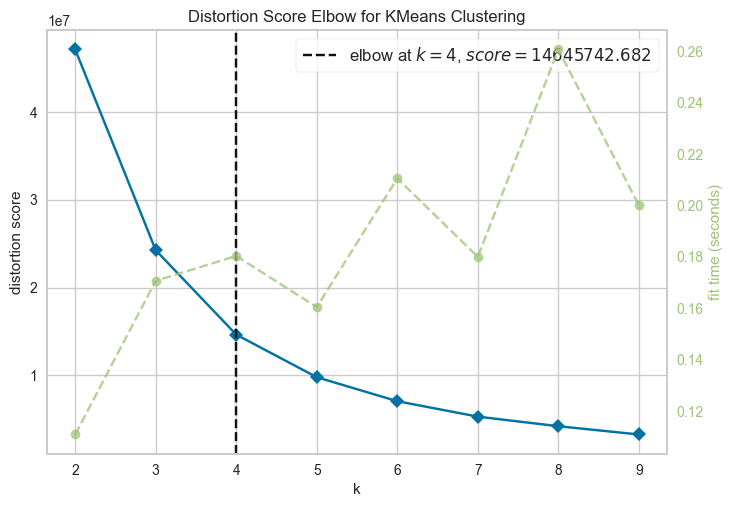

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [515]:
km = KMeans(random_state = 42)
visualizer = KElbowVisualizer(km, k = (2,10))
visualizer.fit(x[['Recency']])
visualizer.show()

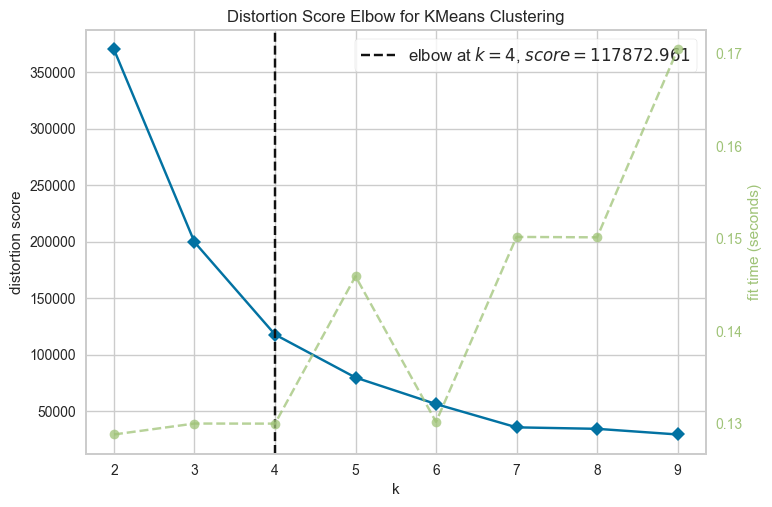

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [516]:
km = KMeans(random_state = 42)
visualizer = KElbowVisualizer(km, k = (2,10))
visualizer.fit(x[['Frequency']])
visualizer.show()

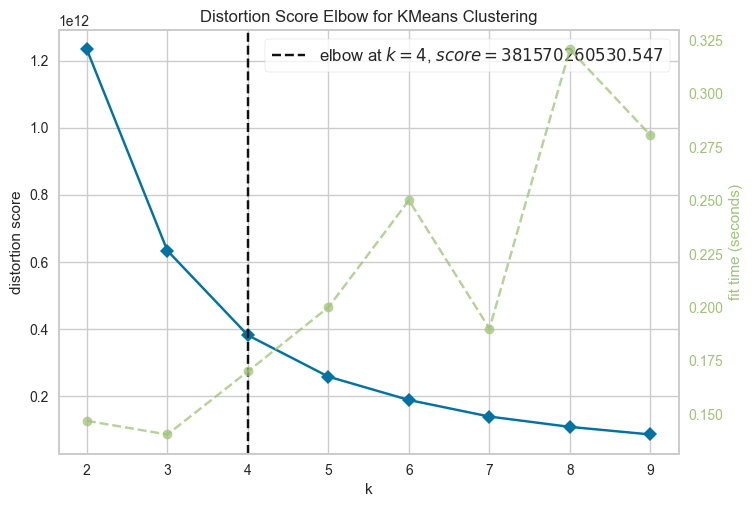

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [517]:
km = KMeans(random_state = 42)
visualizer = KElbowVisualizer(km, k = (2,10))
visualizer.fit(x[['Monetary']])
visualizer.show()

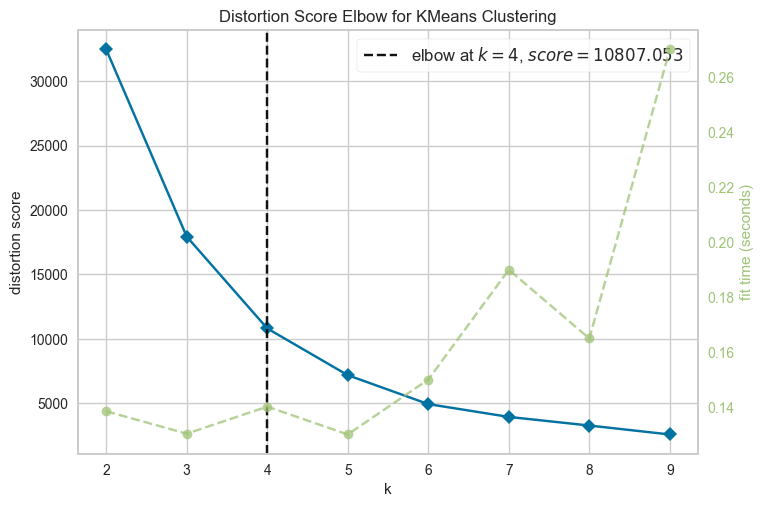

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [518]:
km = KMeans(random_state = 42)
visualizer = KElbowVisualizer(km, k = (2,10))
visualizer.fit(x[['Feedback']])
visualizer.show()

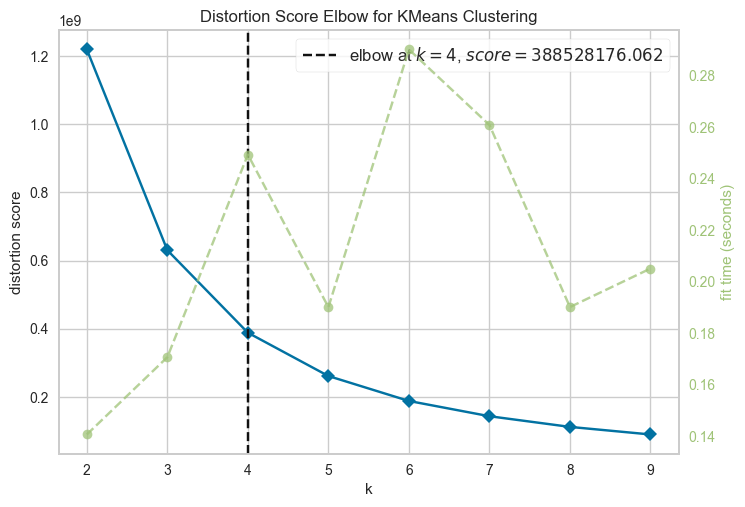

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [519]:
km = KMeans(random_state = 42)
visualizer = KElbowVisualizer(km, k = (2,10))
visualizer.fit(x[['Interaction']])
visualizer.show()


KeyboardInterrupt



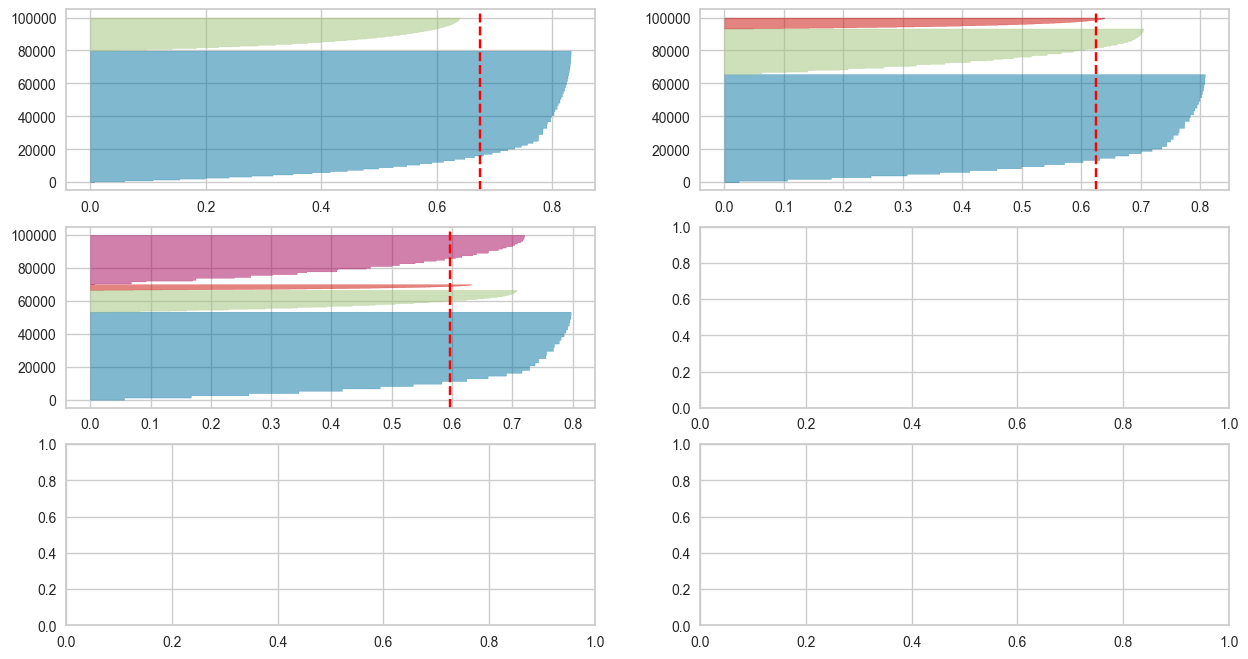

In [33]:
fig, ax = plt.subplots(3,2,figsize=(15,8))
for i in [2,3,4,5] :
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100,random_state=42)
    q,mod = divmod(i,2)
    visualizer = SilhouetteVisualizer(km,colors='yellowbrick',ax=ax[q-1][mod])
    visualizer.fit(x[['Recency']])

KeyboardInterrupt: 

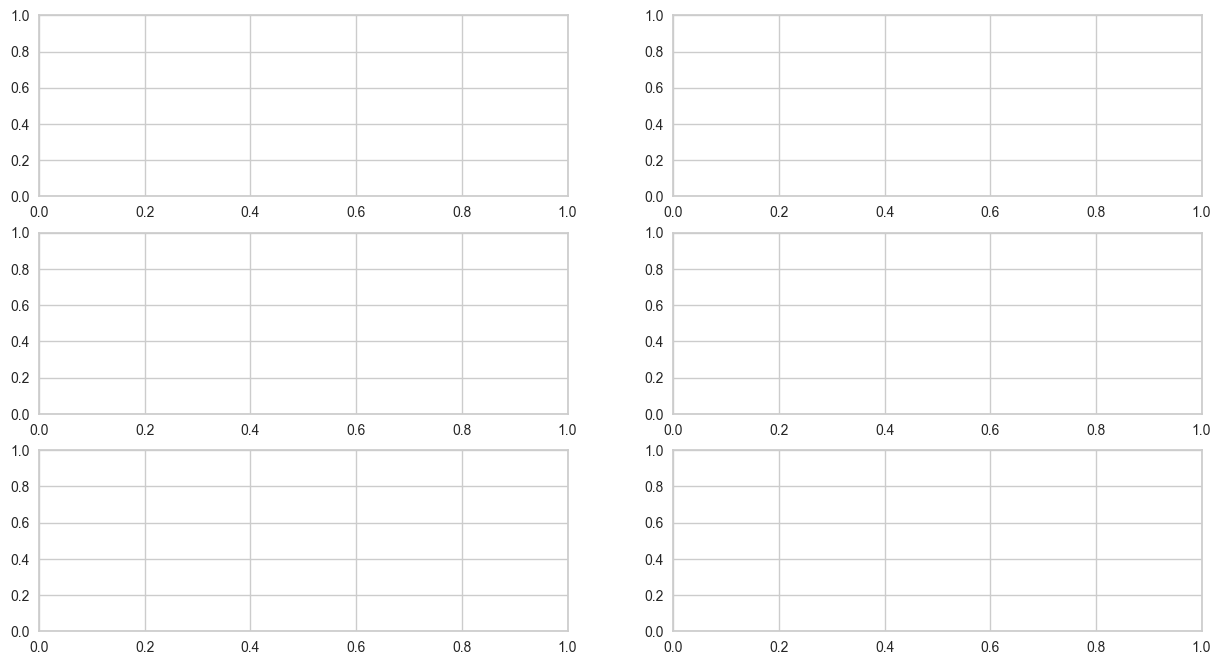

In [38]:
fig, ax = plt.subplots(3,2,figsize=(15,8))
for i in [2,3,4,5] :
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100,random_state=42)
    q,mod = divmod(i,2)
    visualizer = SilhouetteVisualizer(km,colors='yellowbrick',ax=ax[q-1][mod])
    visualizer.fit(x[['Frequency']])

In [ ]:
fig, ax = plt.subplots(3,2,figsize=(15,8))
for i in [2,3,4,5] :
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100,random_state=42)
    q,mod = divmod(i,2)
    visualizer = SilhouetteVisualizer(km,colors='yellowbrick',ax=ax[q-1][mod])
    visualizer.fit(x[['Monetary']])

In [ ]:
fig, ax = plt.subplots(3,2,figsize=(15,8))
for i in [2,3,4,5] :
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100,random_state=42)
    q,mod = divmod(i,2)
    visualizer = SilhouetteVisualizer(km,colors='yellowbrick',ax=ax[q-1][mod])
    visualizer.fit(x[['Feedback']])

In [ ]:
fig, ax = plt.subplots(3,2,figsize=(15,8))
for i in [2,3,4,5] :
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100,random_state=42)
    q,mod = divmod(i,2)
    visualizer = SilhouetteVisualizer(km,colors='yellowbrick',ax=ax[q-1][mod])
    visualizer.fit(x[['Interaction']])

In [520]:
data = x
# Select the columns you want to apply KMeans on
columns = ['Recency', 'Frequency', 'Monetary', 'Feedback', 'Interaction']

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[columns])

# Initialize an empty dictionary to store the cluster scores for each column
cluster_scores = {}

# Apply KMeans clustering for each feature
for i, column in enumerate(columns):
    kmeans = KMeans(n_clusters=4, random_state=0)  # Use n_clusters=4 or any number based on your preference
    data[f'{column}_Cluster'] = kmeans.fit_predict(data_scaled[:, i].reshape(-1, 1))
    
    # Store the cluster labels
    cluster_scores[column] = data[f'{column}_Cluster']

# Print the dataframe with cluster labels
data

,user_id,Recency,Frequency,Monetary,Feedback,Interaction,Recency_Cluster,Frequency_Cluster,Monetary_Cluster,Feedback_Cluster,Interaction_Cluster
0,1,17,14,18845.53,-1.20,803,0,0,3,0,1
1,2,6,13,7088.22,1.00,580,0,0,0,3,3
2,3,12,8,6241.12,-0.80,465,0,2,1,0,0
3,4,42,14,13920.68,-2.10,822,2,0,2,1,1
4,5,6,9,6851.89,-2.20,201,0,2,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...
99984,99996,0,10,9310.30,-1.00,516,0,2,0,0,3
99985,99997,13,8,5169.92,-1.60,355,0,2,1,1,0
99986,99998,44,11,9319.30,-1.20,694,2,0,0,0,3
99987,99999,23,12,7943.73,-0.40,764,0,0,0,2,1


In [521]:
mapping = {
    0: 3,
    2: 2,
    3: 1,
    1: 0
}
data['Recency_Score'] = data['Recency_Cluster'].map(mapping)
mapping = {
    3: 3,
    0: 2,
    2: 1,
    1: 0
}
data['Frequency_Score'] = data['Frequency_Cluster'].map(mapping)
mapping = {
    3: 3,
    2: 2,
    0: 1,
    1: 0
}
data['Monetary_Score'] = data['Monetary_Cluster'].map(mapping)
mapping = {
    3: 3,
    2: 2,
    0: 1,
    1: 0
}
data['Feedback_Score'] = data['Feedback_Cluster'].map(mapping)
mapping = {
    1: 3,
    3: 2,
    2: 0,
    0: 1
}
data['Interaction_Score'] = data['Interaction_Cluster'].map(mapping)
data

,user_id,Recency,Frequency,Monetary,Feedback,Interaction,Recency_Cluster,Frequency_Cluster,Monetary_Cluster,Feedback_Cluster,Interaction_Cluster,Recency_Score,Frequency_Score,Monetary_Score,Feedback_Score,Interaction_Score
0,1,17,14,18845.53,-1.20,803,0,0,3,0,1,3,2,3,1,3
1,2,6,13,7088.22,1.00,580,0,0,0,3,3,3,2,1,3,2
2,3,12,8,6241.12,-0.80,465,0,2,1,0,0,3,1,0,1,1
3,4,42,14,13920.68,-2.10,822,2,0,2,1,1,2,2,2,0,3
4,5,6,9,6851.89,-2.20,201,0,2,0,1,2,3,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99984,99996,0,10,9310.30,-1.00,516,0,2,0,0,3,3,1,1,1,2
99985,99997,13,8,5169.92,-1.60,355,0,2,1,1,0,3,1,0,0,1
99986,99998,44,11,9319.30,-1.20,694,2,0,0,0,3,2,2,1,1,2
99987,99999,23,12,7943.73,-0.40,764,0,0,0,2,1,3,2,1,2,3


In [522]:
copy = data[['user_id','Recency','Frequency','Monetary','Feedback','Interaction','Recency_Score','Frequency_Score','Monetary_Score','Feedback_Score','Interaction_Score']]
copy['Overall_Score'] = (
    copy['Recency_Score'] +
    copy['Frequency_Score'] +
    copy['Monetary_Score'] +
    copy['Feedback_Score'] +
    copy['Interaction_Score']
)
copy

,user_id,Recency,Frequency,Monetary,Feedback,Interaction,Recency_Score,Frequency_Score,Monetary_Score,Feedback_Score,Interaction_Score,Overall_Score
0,1,17,14,18845.53,-1.20,803,3,2,3,1,3,12
1,2,6,13,7088.22,1.00,580,3,2,1,3,2,11
2,3,12,8,6241.12,-0.80,465,3,1,0,1,1,6
3,4,42,14,13920.68,-2.10,822,2,2,2,0,3,9
4,5,6,9,6851.89,-2.20,201,3,1,1,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
99984,99996,0,10,9310.30,-1.00,516,3,1,1,1,2,8
99985,99997,13,8,5169.92,-1.60,355,3,1,0,0,1,5
99986,99998,44,11,9319.30,-1.20,694,2,2,1,1,2,8
99987,99999,23,12,7943.73,-0.40,764,3,2,1,2,3,11


In [523]:
for i in ['Recency', 'Frequency', 'Monetary', 'Feedback', 'Interaction']:
    column = i
    print(column)
    for j in range(0,4):
        print(f"Score {j} ranges from : {copy[column][copy[f'{column}_Score'] == j].min()} to {copy[column][copy[f'{column}_Score'] == j].max()}")

Recency
Score 0 ranges from : 121 to 361
Score 1 ranges from : 63 to 120
Score 2 ranges from : 27 to 62
Score 3 ranges from : 0 to 26
Frequency
Score 0 ranges from : 1 to 7
Score 1 ranges from : 8 to 10
Score 2 ranges from : 11 to 14
Score 3 ranges from : 15 to 25
Monetary
Score 0 ranges from : 0.0 to 6535.34
Score 1 ranges from : 6535.360000000001 to 12027.0
Score 2 ranges from : 12027.21 to 18534.19
Score 3 ranges from : 18535.41 to 41488.58
Feedback
Score 0 ranges from : -5.6 to -1.4999999999999998
Score 1 ranges from : -1.4000000000000001 to -0.5999999999999999
Score 2 ranges from : -0.5000000000000001 to 0.3000000000000001
Score 3 ranges from : 0.39999999999999986 to 3.0
Interaction
Score 0 ranges from : 1 to 340
Score 1 ranges from : 341 to 511
Score 2 ranges from : 512 to 706
Score 3 ranges from : 707 to 1496


In [524]:
print(f"Overall Cluster Score ranges from : {copy['Overall_Score'].min()} to {copy['Overall_Score'].max()}")

Overall Cluster Score ranges from : 0 to 15


In [525]:
copy.sort_values('Overall_Score')

,user_id,Recency,Frequency,Monetary,Feedback,Interaction,Recency_Score,Frequency_Score,Monetary_Score,Feedback_Score,Interaction_Score,Overall_Score
65745,65754,130,6,2597.96,-1.50,307,0,0,0,0,0,0
50346,50354,199,7,6463.77,-1.50,196,0,0,0,0,0,0
52867,52875,131,5,2977.23,-1.50,144,0,0,0,0,0,0
17325,17330,142,6,0.00,-1.50,165,0,0,0,0,0,0
3435,3436,123,6,3065.30,-1.50,257,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
31131,31138,3,17,24910.50,0.50,1007,3,3,3,3,3,15
87175,87187,5,19,21132.85,0.40,830,3,3,3,3,3,15
33811,33818,0,17,19247.60,0.50,898,3,3,3,3,3,15
98024,98036,2,18,27829.03,0.50,1141,3,3,3,3,3,15


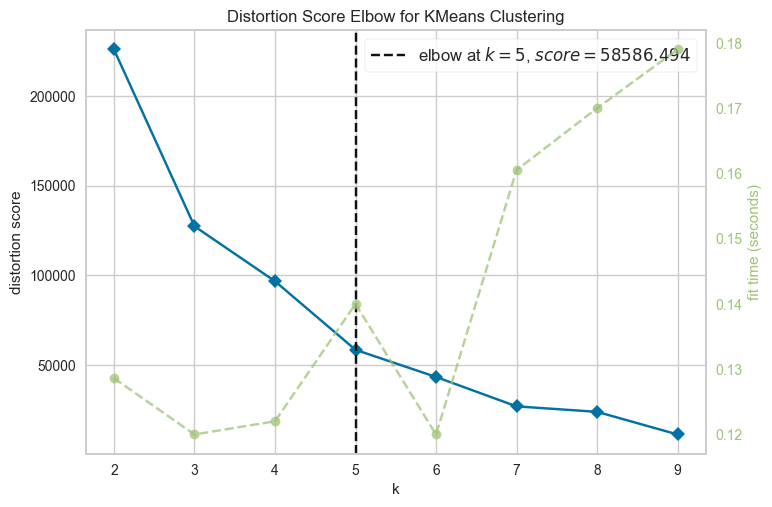

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [464]:
km = KMeans(random_state = 42)
visualizer = KElbowVisualizer(km, k = (2,10))
visualizer.fit(copy[['Overall_Score']])
visualizer.show()

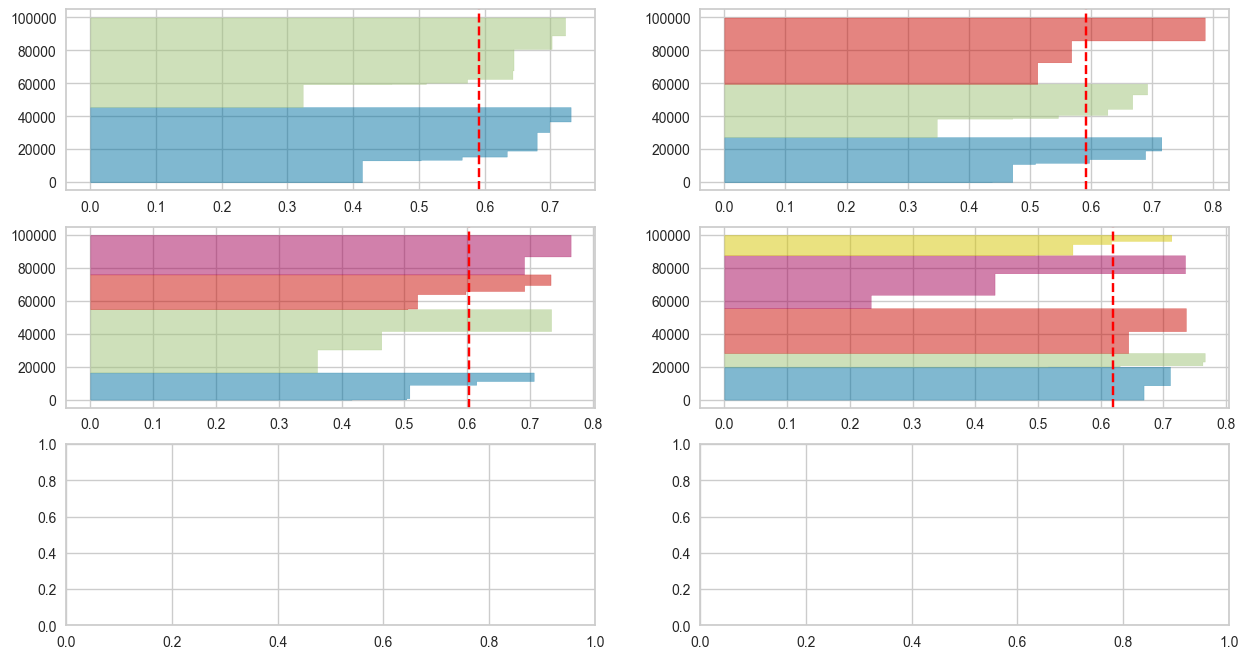

In [434]:
fig, ax = plt.subplots(3,2,figsize=(15,8))
for i in [2,3,4,5] :
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100,random_state=42)
    q,mod = divmod(i,2)
    visualizer = SilhouetteVisualizer(km,colors='yellowbrick',ax=ax[q-1][mod])
    visualizer.fit(copy[['Overall_Score']])

In [526]:
# Define the bins and labels
bins = [0,3,7,11,15]
labels = ['Low Value','Medium Value', 'High Value' ,'Very High Value']

# Create a new column with the binned values
copy['Value_Category'] = pd.cut(copy['Overall_Score'], bins=bins, labels=labels, include_lowest=True)
copy

,user_id,Recency,Frequency,Monetary,Feedback,Interaction,Recency_Score,Frequency_Score,Monetary_Score,Feedback_Score,Interaction_Score,Overall_Score,Value_Category
0,1,17,14,18845.53,-1.20,803,3,2,3,1,3,12,Very High Value
1,2,6,13,7088.22,1.00,580,3,2,1,3,2,11,High Value
2,3,12,8,6241.12,-0.80,465,3,1,0,1,1,6,Medium Value
3,4,42,14,13920.68,-2.10,822,2,2,2,0,3,9,High Value
4,5,6,9,6851.89,-2.20,201,3,1,1,0,0,5,Medium Value
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99984,99996,0,10,9310.30,-1.00,516,3,1,1,1,2,8,High Value
99985,99997,13,8,5169.92,-1.60,355,3,1,0,0,1,5,Medium Value
99986,99998,44,11,9319.30,-1.20,694,2,2,1,1,2,8,High Value
99987,99999,23,12,7943.73,-0.40,764,3,2,1,2,3,11,High Value


In [575]:
low = copy[copy['Value_Category'] == 'Low Value']
medium = copy[copy['Value_Category'] == 'Medium Value']
high = copy[copy['Value_Category'] == 'High Value']
very_high = copy[copy['Value_Category'] == 'Very High Value']


In [635]:
def calculate_feature_data(temporal_in_data, train_data):
    # Get unique user IDs from low_training_data
    user_ids = train_data['user_id'].unique()

    # Extract rows from df where the user_id is in low_user_ids
    segment_feature_data = temporal_in_data[temporal_in_data['user_id'].isin(user_ids)]

    # Total Order Value & its Mean
    monetary_features_data = segment_feature_data\
                             .groupby('user_id')\
                             .aggregate({'order_value' : ['sum','mean']})\
                             .set_axis(['order_value_sum','order_value_mean'], axis = 1)
    # Transactions within the Last Month
    cutoff_28d = cutoff - pd.to_timedelta(28, unit = "d")
    transactions_last_month_data = segment_feature_data[['user_id','order_date']]\
                                   .drop_duplicates()\
                                   .query('order_date >= @cutoff_28d')\
                                   .groupby('user_id')\
                                   .size()\
                                   .to_frame()\
                                   .set_axis(['transactions_last_month'], axis = 1)
    # Transactions Last 2 Weeks
    cutoff_14d = cutoff - pd.to_timedelta(14, unit = "d")
    transactions_last_2weeks_data = segment_feature_data[['user_id','order_date']]\
                                   .drop_duplicates()\
                                   .query('order_date >= @cutoff_14d')\
                                   .groupby('user_id')\
                                   .size()\
                                   .to_frame()\
                                   .set_axis(['transactions_last_2weeks'], axis = 1) 
    # Spend/Revenue Last 2 Weeks
    cutoff_14d = cutoff - pd.to_timedelta(14, unit = "d")
    sales_last_2weeks_data = segment_feature_data[['user_id','order_date','order_value']]\
                                   .drop_duplicates()\
                                   .query('order_date >= @cutoff_14d')\
                                   .groupby('user_id')\
                                   .agg({'order_value': 'sum'})\
                                   .set_axis(['sales_last_2weeks'], axis = 1)
    # Spend/Revenue Last 1 Month
    cutoff_28d = cutoff - pd.to_timedelta(28, unit = "d")
    sales_last_month_data = segment_feature_data[['user_id','order_date','order_value']]\
                                   .drop_duplicates()\
                                   .query('order_date >= @cutoff_28d')\
                                   .groupby('user_id')\
                                   .agg({'order_value': 'sum'})\
                                   .set_axis(['sales_last_month'], axis = 1)

    # Ensure 'user_id' is set as the index for all DataFrames
    train_data.set_index('user_id', inplace=True)
    #monetary_features_data.set_index('user_id', inplace=True)
    #transactions_last_month_data.set_index('user_id', inplace=True)
    #transactions_last_2weeks_data.set_index('user_id', inplace=True)
    #sales_last_2weeks_data.set_index('user_id', inplace=True)
    #sales_last_month_data.set_index('user_id', inplace=True)

    # Merge all DataFrames on 'user_id'
    features_data = train_data.merge(monetary_features_data, on='user_id', how='left')
    features_data = features_data.merge(transactions_last_month_data, on='user_id', how='left')
    features_data = features_data.merge(transactions_last_2weeks_data, on='user_id', how='left')
    features_data = features_data.merge(sales_last_2weeks_data, on='user_id', how='left')
    features_data = features_data.merge(sales_last_month_data, on='user_id', how='left')

    # Drop Categorical Columns
    features_data = features_data.drop(['Value_Category'], axis = 1)
    
    # Fill NaNs with 0
    features_data.fillna(0, inplace=True)

    # Reset the index if needed
    #features_data.reset_index(inplace=True)

    return features_data

In [577]:
low = calculate_feature_data(sample,low)
low

,Recency,Frequency,Monetary,Feedback,Interaction,Recency_Score,Frequency_Score,Monetary_Score,Feedback_Score,Interaction_Score,Overall_Score,order_value_sum,order_value_mean,transactions_last_month,transactions_last_2weeks,sales_last_2weeks,sales_last_month
user_id,,,,,,,,,,,,,,,,,
5,132,6,2860.67,-0.90,164,0,1,0,1,0,2,24505.17,2722.80,3.00,3.00,8848.79,8848.79
14,139,4,4429.41,-0.30,196,0,0,0,2,0,2,14637.06,1829.63,4.00,4.00,7438.90,7438.90
35,73,4,3299.63,-0.60,221,1,0,0,1,0,2,17157.10,2451.01,3.00,3.00,2384.91,2384.91
36,30,4,3020.06,-1.00,204,2,0,0,1,0,3,11749.99,1958.33,2.00,2.00,1430.13,1430.13
49,61,4,3957.14,-0.60,166,2,0,0,1,0,3,11472.73,1912.12,2.00,2.00,5071.88,5071.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99960,61,4,4021.48,-1.20,158,2,0,0,1,0,3,16345.46,2043.18,4.00,4.00,7170.53,7170.53
99963,81,4,3624.28,-0.30,167,1,0,0,2,0,3,12990.68,1623.84,4.00,4.00,7382.09,7382.09
99969,142,6,4206.54,-1.20,329,0,1,0,1,1,3,16494.79,2356.40,1.00,1.00,1924.94,1924.94


In [657]:
clf_predictions_data = clf.predict_model(xgb_clf_model, data = very_high, raw_score = True)\
                        .sort_values('prediction_score_1', ascending = False)
clf_predictions_data = clf_predictions_data.drop(['prediction_score_0','prediction_score_1'],axis=1)
clf_predictions_data.rename(columns={'prediction_label': 'future_churn'}, inplace=True)

clf_predictions_data

,Recency,Frequency,Monetary,Feedback,Interaction,Recency_Score,Frequency_Score,Monetary_Score,Feedback_Score,Interaction_Score,Overall_Score,order_value_sum,order_value_mean,transactions_last_month,transactions_last_2weeks,sales_last_2weeks,sales_last_month,future_churn
user_id,,,,,,,,,,,,,,,,,,
53340,6,8,9477.97,1.60,403,3,2,2,3,2,12,22137.32,2767.17,2.00,2.00,8244.50,8244.50,1
36258,34,12,10544.68,1.20,558,2,3,2,3,2,12,44471.81,2964.79,3.00,3.00,9547.68,9547.68,1
87860,59,9,17560.71,0.60,397,2,2,3,3,2,12,26640.71,2421.88,2.00,2.00,2816.32,2816.32,1
88521,17,9,9675.49,0.40,395,3,2,2,3,2,12,21888.30,2188.83,3.00,1.00,1494.52,6925.81,1
14655,5,11,7698.52,-0.00,594,3,3,1,2,3,12,49623.93,3817.23,4.00,3.00,11569.58,16036.01,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61107,9,14,15112.91,-0.30,553,3,3,3,2,2,13,36648.33,2617.74,4.00,1.00,3787.50,11287.54,0
62204,26,8,13435.63,1.60,443,3,2,2,3,2,12,29949.89,3743.74,1.00,0.00,0.00,3643.41,0
17856,35,13,23793.14,0.30,761,2,3,3,2,3,13,34885.69,2683.51,0.00,0.00,0.00,0.00,0


In [658]:
reg_predictions_data = reg.predict_model(xgb_reg_model, data = clf_predictions_data)\
                       .sort_values('prediction_label', ascending = False)
reg_predictions_data

,Recency,Frequency,Monetary,Feedback,Interaction,Recency_Score,Frequency_Score,Monetary_Score,Feedback_Score,Interaction_Score,Overall_Score,order_value_sum,order_value_mean,transactions_last_month,transactions_last_2weeks,sales_last_2weeks,sales_last_month,future_churn,prediction_label
user_id,,,,,,,,,,,,,,,,,,,
21730,22,11,11019.03,0.80,522,3,3,2,3,2,13,27442.83,1715.18,6.00,5.00,4731.33,9807.82,1,19489.07
82799,15,11,9383.51,0.40,508,3,3,2,3,2,13,37933.07,2231.36,7.00,6.00,13343.11,14962.15,1,19106.91
663,15,10,9290.47,-0.10,464,3,3,2,2,2,12,33075.81,2205.05,7.00,5.00,12398.38,18913.57,1,19086.28
5522,8,15,10179.68,-1.40,570,3,3,2,1,3,12,29217.29,1623.18,4.00,4.00,12409.19,12409.19,1,18870.69
20717,10,11,10191.18,-0.20,575,3,3,2,2,3,13,35475.96,2217.25,9.00,6.00,14638.85,19716.82,1,18419.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69016,21,11,15582.42,-1.00,766,3,3,3,1,3,13,26079.04,2370.82,1.00,0.00,0.00,3087.72,0,-2102.86
69737,40,10,20289.05,-0.90,615,2,3,3,1,3,12,32846.57,3284.66,0.00,0.00,0.00,0.00,0,-2303.95
67200,7,14,17075.40,-1.50,679,3,3,3,0,3,12,37977.49,2712.68,3.00,1.00,2455.20,11117.00,0,-2504.75


In [660]:
reg_predictions_data['Expected_CLV'] = reg_predictions_data['prediction_label']*0.15*reg_predictions_data['future_churn']
reg_predictions_data['Monetary'].mean(), reg_predictions_data['Expected_CLV'].mean()
reg_predictions_data[reg_predictions_data['future_churn'] == 0].count()

Recency                     436
Frequency                   436
Monetary                    436
Feedback                    436
Interaction                 436
Recency_Score               436
Frequency_Score             436
Monetary_Score              436
Feedback_Score              436
Interaction_Score           436
Overall_Score               436
order_value_sum             436
order_value_mean            436
transactions_last_month     436
transactions_last_2weeks    436
sales_last_2weeks           436
sales_last_month            436
future_churn                436
prediction_label            436
Expected_CLV                436
dtype: int64

In [584]:
medium = calculate_feature_data(sample,medium)
medium

,Recency,Frequency,Monetary,Feedback,Interaction,Recency_Score,Frequency_Score,Monetary_Score,Feedback_Score,Interaction_Score,Overall_Score,order_value_sum,order_value_mean,transactions_last_month,transactions_last_2weeks,sales_last_2weeks,sales_last_month
user_id,,,,,,,,,,,,,,,,,
3,33,6,4852.62,-1.20,381,2,1,1,1,1,6,14347.90,1793.49,2.00,2.00,1388.50,1388.50
6,93,4,6930.25,0.00,129,1,0,1,2,0,4,16651.50,2775.25,2.00,2.00,1410.57,1410.57
8,67,9,7824.39,-1.20,269,1,2,1,1,1,6,32119.24,2676.60,3.00,3.00,7158.78,7158.78
9,19,5,6768.65,-0.60,261,3,1,1,1,1,7,14989.48,2141.35,3.00,2.00,3192.14,5707.52
11,38,5,4720.91,-0.30,189,2,1,1,2,0,6,16221.64,2027.70,3.00,3.00,5801.21,5801.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99986,105,6,7770.12,-0.90,198,1,1,1,1,0,4,20582.39,2572.80,2.00,2.00,3787.55,3787.55
99987,2,4,1193.05,-0.10,271,3,0,0,2,1,6,17668.18,2524.03,4.00,4.00,9491.92,9491.92
99990,140,5,11526.86,-0.30,202,0,1,2,2,0,5,12417.48,2483.50,0.00,0.00,0.00,0.00


In [610]:
high = calculate_feature_data(sample,high)
high

,Recency,Frequency,Monetary,Feedback,Interaction,Recency_Score,Frequency_Score,Monetary_Score,Feedback_Score,Interaction_Score,Overall_Score,order_value_sum,order_value_mean,transactions_last_month,transactions_last_2weeks,sales_last_2weeks,sales_last_month
user_id,,,,,,,,,,,,,,,,,
2,4,10,7088.22,0.20,360,3,3,1,2,1,10,25884.81,1991.14,4.00,3.00,11323.61,12007.55
4,6,12,11694.65,-1.50,733,3,3,2,0,3,11,33029.83,2359.27,3.00,3.00,6647.65,6647.65
10,4,10,5977.11,-0.60,599,3,3,1,1,3,11,27744.42,2134.19,4.00,4.00,17668.22,17668.22
12,36,11,10905.59,-0.90,640,2,3,2,1,3,11,33608.53,2400.61,3.00,3.00,9387.89,9387.89
16,1,10,13104.91,-2.50,463,3,3,2,0,2,10,27288.96,2480.81,3.00,3.00,5005.80,5005.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,19,6,11012.95,0.40,341,3,1,2,3,1,10,17694.44,2527.78,2.00,1.00,2241.95,5283.61
99996,9,9,9310.30,-0.70,445,3,2,2,1,2,10,26316.12,2631.61,2.00,2.00,4026.05,4026.05
99998,42,9,8999.69,-1.20,594,2,2,1,1,3,9,24003.29,2182.12,2.00,2.00,4174.99,4174.99


In [636]:
very_high = calculate_feature_data(sample,very_high)
very_high

,Recency,Frequency,Monetary,Feedback,Interaction,Recency_Score,Frequency_Score,Monetary_Score,Feedback_Score,Interaction_Score,Overall_Score,order_value_sum,order_value_mean,transactions_last_month,transactions_last_2weeks,sales_last_2weeks,sales_last_month
user_id,,,,,,,,,,,,,,,,,
1,15,12,15861.73,-0.90,710,3,3,3,1,3,13,37243.57,2660.26,3.00,2.00,4933.51,9380.82
7,19,7,11974.13,1.00,415,3,2,2,3,2,12,22529.69,2816.21,2.00,1.00,4865.33,9040.61
25,47,11,20591.98,-1.20,614,2,3,3,1,3,12,48322.39,2684.58,7.00,7.00,16732.30,16732.30
39,28,13,16180.50,0.70,629,3,3,3,3,3,15,46702.74,3113.52,3.00,2.00,4955.38,12689.29
44,9,12,21501.19,-0.90,496,3,3,3,1,2,12,40599.41,2706.63,5.00,4.00,13577.41,15410.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99970,23,11,11620.89,1.00,445,3,3,2,3,2,13,36390.77,2140.63,7.00,6.00,11220.60,14292.36
99974,4,10,19157.97,-0.30,400,3,3,3,2,2,13,31104.04,2592.00,4.00,3.00,7588.90,9684.98
99975,2,10,6708.95,0.60,653,3,3,1,3,3,13,38404.53,2954.19,5.00,5.00,13814.11,13814.11


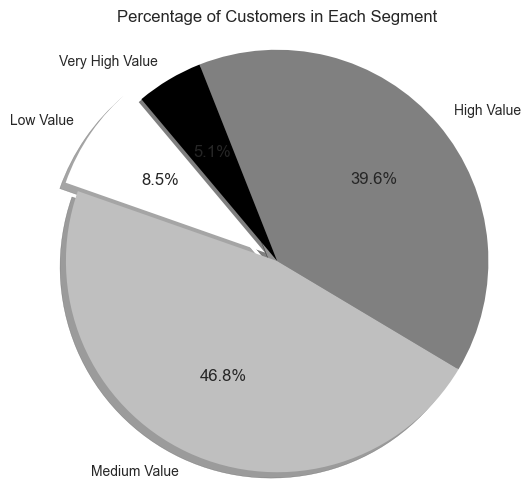

In [538]:
# Data for pie chart
labels = ['Low Value', 'Medium Value', 'High Value', 'Very High Value']
sizes = [low, medium, high, very_high]
# Define shades of black
colors = ['#ffffff', '#bfbfbf', '#808080', '#000000'] 
# Pie chart, where the slices will be ordered and plotted
plt.figure(figsize=(6, 6))
plt.pie(sizes, colors = colors,labels=labels, autopct='%1.1f%%',explode=(0.07, 0, 0, 0), startangle=130,shadow = True)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Display the pie chart
plt.title('Percentage of Customers in Each Segment')
plt.show()


In [637]:
sample

,order_id,order_date,user_id,order_value,category,quantity,order_status,supplier_id,feedback,clicks_count,app_open_count
0,0,2023-09-26,14225,4044.37,Home Goods,1,cancelled,565,Negative feedback,1,4
1,1,2024-09-08,19369,2969.24,Clothing,10,cancelled,222,Positive feedback,11,46
2,2,2024-03-08,339,4985.45,Electronics,2,cancelled,907,Neutral feedback,44,48
3,3,2023-11-26,19310,4328.57,Clothing,4,delivered,176,Neutral feedback,37,42
4,4,2023-11-20,13523,2517.05,Home Goods,1,delivered,207,Negative feedback,10,19
...,...,...,...,...,...,...,...,...,...,...,...
999995,999995,2023-10-04,11904,896.17,Home Goods,9,cancelled,769,Negative feedback,16,35
999996,999996,2023-12-14,83686,828.17,Clothing,5,returned,968,Positive feedback,7,27
999997,999997,2024-07-09,37213,4156.44,Electronics,6,delivered,745,Neutral feedback,6,7
999998,999998,2024-08-17,99950,4931.21,Home Goods,6,exchanged,423,Negative feedback,5,8


In [638]:
import pytimetk as tk
import pycaret.classification as clf
import pycaret.regression as reg
from pycaret.classification import *

profit_margin = 0.15 
n_days = 90
max_date = sample['order_date'].max()
cutoff = max_date - pd.to_timedelta(n_days, unit = "d")
cutoff

Timestamp('2024-06-12 00:00:00')

In [639]:
temporal_in_data = sample[sample['order_date'] < cutoff]
temporal_out_data = sample[sample['order_date'] >= cutoff]\
                        .query('user_id in @temporal_in_data.user_id')
temporal_out_data.glimpse()

<class 'pandas.core.frame.DataFrame'>: 249208 rows of 11 columns
order_id:        int64             [1, 6, 17, 21, 24, 25, 26, 27, 31, 33 ...
order_date:      datetime64[ns]    [Timestamp('2024-09-08 00:00:00'), Ti ...
user_id:         int64             [19369, 60030, 90055, 97604, 74900, 7 ...
order_value:     float64           [2969.24, 4605.76, 4998.3, 3933.68, 1 ...
category:        object            ['Clothing', 'Electronics', 'Home Goo ...
quantity:        int64             [10, 1, 8, 1, 4, 10, 5, 9, 10, 1, 5,  ...
order_status:    object            ['cancelled', 'exchanged', 'RTO', 'RT ...
supplier_id:     int64             [222, 679, 592, 478, 215, 281, 582, 6 ...
feedback:        object            ['Positive feedback', 'Neutral feedba ...
clicks_count:    int64             [11, 5, 0, 12, 4, 15, 12, 9, 8, 16, 4 ...
app_open_count:  int64             [46, 23, 11, 39, 9, 29, 19, 19, 15, 4 ...


In [640]:
temporal_in_data

,order_id,order_date,user_id,order_value,category,quantity,order_status,supplier_id,feedback,clicks_count,app_open_count
0,0,2023-09-26,14225,4044.37,Home Goods,1,cancelled,565,Negative feedback,1,4
2,2,2024-03-08,339,4985.45,Electronics,2,cancelled,907,Neutral feedback,44,48
3,3,2023-11-26,19310,4328.57,Clothing,4,delivered,176,Neutral feedback,37,42
4,4,2023-11-20,13523,2517.05,Home Goods,1,delivered,207,Negative feedback,10,19
5,5,2023-11-17,38526,4102.04,Clothing,10,cancelled,658,Negative feedback,12,47
...,...,...,...,...,...,...,...,...,...,...,...
999993,999993,2023-10-03,7913,383.96,Electronics,5,delivered,917,Negative feedback,23,48
999994,999994,2024-01-10,45829,682.12,Electronics,8,cancelled,544,Negative feedback,3,33
999995,999995,2023-10-04,11904,896.17,Home Goods,9,cancelled,769,Negative feedback,16,35
999996,999996,2023-12-14,83686,828.17,Clothing,5,returned,968,Positive feedback,7,27


In [641]:
x = calculate_rfm(temporal_in_data,'user_id','order_id','order_date','order_value',cutoff)
y = calculate_feedback(temporal_in_data,'user_id','feedback','order_date',cutoff)
z = calculate_interaction(temporal_in_data,'user_id','clicks_count','app_open_count')
x['Feedback'] = y['Weighted Feedback Score']
x['Interaction'] = z['Weighted Interaction Score']
x

,user_id,Recency,Frequency,Monetary,Feedback,Interaction
0,1,15,12,15861.73,-0.90,710
1,2,4,10,7088.22,0.20,360
2,3,33,6,4852.62,-1.20,381
3,4,6,12,11694.65,-1.50,733
4,5,132,6,2860.67,-0.90,164
...,...,...,...,...,...,...
99922,99996,9,9,9310.30,-0.70,445
99923,99997,9,5,3056.82,-1.30,193
99924,99998,42,9,8999.69,-1.20,594
99925,99999,9,10,3248.65,-0.00,652


In [642]:
# Select the columns you want to apply KMeans on
columns = ['Recency', 'Frequency', 'Monetary', 'Feedback', 'Interaction']

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(x[columns])

# Initialize an empty dictionary to store the cluster scores for each column
cluster_scores = {}

# Apply KMeans clustering for each feature
for i, column in enumerate(columns):
    kmeans = KMeans(n_clusters=4, random_state=0)  # Use n_clusters=4 or any number based on your preference
    x[f'{column}_Cluster'] = kmeans.fit_predict(data_scaled[:, i].reshape(-1, 1))
    
    # Store the cluster labels
    cluster_scores[column] = x[f'{column}_Cluster']

# Print the dataframe with cluster labels
x

,user_id,Recency,Frequency,Monetary,Feedback,Interaction,Recency_Cluster,Frequency_Cluster,Monetary_Cluster,Feedback_Cluster,Interaction_Cluster
0,1,15,12,15861.73,-0.90,710,0,1,0,0,2
1,2,4,10,7088.22,0.20,360,0,1,1,2,0
2,3,33,6,4852.62,-1.20,381,2,3,1,0,0
3,4,6,12,11694.65,-1.50,733,0,1,2,1,2
4,5,132,6,2860.67,-0.90,164,3,3,3,0,3
...,...,...,...,...,...,...,...,...,...,...,...
99922,99996,9,9,9310.30,-0.70,445,0,0,2,0,1
99923,99997,9,5,3056.82,-1.30,193,0,3,3,0,3
99924,99998,42,9,8999.69,-1.20,594,2,0,1,0,2
99925,99999,9,10,3248.65,-0.00,652,0,1,3,2,2


In [643]:
mapping = {
    0: 3,
    2: 2,
    1: 1,
    3: 0
}
x['Recency_Score'] = x['Recency_Cluster'].map(mapping)
mapping = {
    1: 3,
    0: 2,
    3: 1,
    2: 0
}
x['Frequency_Score'] = x['Frequency_Cluster'].map(mapping)
mapping = {
    0: 3,
    2: 2,
    1: 1,
    3: 0
}
x['Monetary_Score'] = x['Monetary_Cluster'].map(mapping)
mapping = {
    3: 3,
    2: 2,
    0: 1,
    1: 0
}
x['Feedback_Score'] = x['Feedback_Cluster'].map(mapping)
mapping = {
    2: 3,
    1: 2,
    0: 1,
    3: 0
}
x['Interaction_Score'] = x['Interaction_Cluster'].map(mapping)
x

,user_id,Recency,Frequency,Monetary,Feedback,Interaction,Recency_Cluster,Frequency_Cluster,Monetary_Cluster,Feedback_Cluster,Interaction_Cluster,Recency_Score,Frequency_Score,Monetary_Score,Feedback_Score,Interaction_Score
0,1,15,12,15861.73,-0.90,710,0,1,0,0,2,3,3,3,1,3
1,2,4,10,7088.22,0.20,360,0,1,1,2,0,3,3,1,2,1
2,3,33,6,4852.62,-1.20,381,2,3,1,0,0,2,1,1,1,1
3,4,6,12,11694.65,-1.50,733,0,1,2,1,2,3,3,2,0,3
4,5,132,6,2860.67,-0.90,164,3,3,3,0,3,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99922,99996,9,9,9310.30,-0.70,445,0,0,2,0,1,3,2,2,1,2
99923,99997,9,5,3056.82,-1.30,193,0,3,3,0,3,3,1,0,1,0
99924,99998,42,9,8999.69,-1.20,594,2,0,1,0,2,2,2,1,1,3
99925,99999,9,10,3248.65,-0.00,652,0,1,3,2,2,3,3,0,2,3


In [644]:
copy = x[['user_id','Recency','Frequency','Monetary','Feedback','Interaction','Recency_Score','Frequency_Score','Monetary_Score','Feedback_Score','Interaction_Score']]
copy['Overall_Score'] = (
    copy['Recency_Score'] +
    copy['Frequency_Score'] +
    copy['Monetary_Score'] +
    copy['Feedback_Score'] +
    copy['Interaction_Score']
)
for i in ['Recency', 'Frequency', 'Monetary', 'Feedback', 'Interaction']:
    column = i
    print(column)
    for j in range(0,4):
        print(f"Score {j} ranges from : {copy[column][copy[f'{column}_Score'] == j].min()} to {copy[column][copy[f'{column}_Score'] == j].max()}")

Recency
Score 0 ranges from : 123 to 274
Score 1 ranges from : 67 to 122
Score 2 ranges from : 30 to 66
Score 3 ranges from : 1 to 29
Frequency
Score 0 ranges from : 1 to 4
Score 1 ranges from : 5 to 6
Score 2 ranges from : 7 to 9
Score 3 ranges from : 10 to 22
Monetary
Score 0 ranges from : 0.0 to 4473.61
Score 1 ranges from : 4473.88 to 9114.1
Score 2 ranges from : 9114.37 to 14831.76
Score 3 ranges from : 14831.91 to 37298.85
Feedback
Score 0 ranges from : -5.6 to -1.4999999999999998
Score 1 ranges from : -1.4 to -0.49999999999999983
Score 2 ranges from : -0.40000000000000013 to 0.3000000000000001
Score 3 ranges from : 0.39999999999999986 to 3.0
Interaction
Score 0 ranges from : 0 to 244
Score 1 ranges from : 245 to 392
Score 2 ranges from : 393 to 564
Score 3 ranges from : 565 to 1213


In [645]:
print(f"Overall Cluster Score ranges from : {copy['Overall_Score'].min()} to {copy['Overall_Score'].max()}")
copy.sort_values('Overall_Score')

Overall Cluster Score ranges from : 1 to 15


,user_id,Recency,Frequency,Monetary,Feedback,Interaction,Recency_Score,Frequency_Score,Monetary_Score,Feedback_Score,Interaction_Score,Overall_Score
11673,11681,165,4,3819.57,-0.90,234,0,0,0,1,0,1
47250,47286,216,3,0.00,-0.60,71,0,0,0,1,0,1
62813,62868,125,3,3194.19,-0.60,151,0,0,0,1,0,1
96551,96624,160,2,1340.09,-0.60,43,0,0,0,1,0,1
27853,27876,130,4,1106.64,-0.60,180,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
90026,90097,3,11,15285.93,0.40,631,3,3,3,3,3,15
26685,26707,23,16,25700.25,2.60,680,3,3,3,3,3,15
43983,44018,5,15,21239.84,0.60,694,3,3,3,3,3,15
61651,61702,7,12,15711.95,1.20,743,3,3,3,3,3,15


In [646]:
# Define the bins and labels
bins = [0,3,7,11,15]
labels = ['Low Value','Medium Value', 'High Value' ,'Very High Value']

# Create a new column with the binned values
copy['Value_Category'] = pd.cut(copy['Overall_Score'], bins=bins, labels=labels, include_lowest=True)
copy

,user_id,Recency,Frequency,Monetary,Feedback,Interaction,Recency_Score,Frequency_Score,Monetary_Score,Feedback_Score,Interaction_Score,Overall_Score,Value_Category
0,1,15,12,15861.73,-0.90,710,3,3,3,1,3,13,Very High Value
1,2,4,10,7088.22,0.20,360,3,3,1,2,1,10,High Value
2,3,33,6,4852.62,-1.20,381,2,1,1,1,1,6,Medium Value
3,4,6,12,11694.65,-1.50,733,3,3,2,0,3,11,High Value
4,5,132,6,2860.67,-0.90,164,0,1,0,1,0,2,Low Value
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99922,99996,9,9,9310.30,-0.70,445,3,2,2,1,2,10,High Value
99923,99997,9,5,3056.82,-1.30,193,3,1,0,1,0,5,Medium Value
99924,99998,42,9,8999.69,-1.20,594,2,2,1,1,3,9,High Value
99925,99999,9,10,3248.65,-0.00,652,3,3,0,2,3,11,High Value


In [647]:
copy[copy['Value_Category'] == 'Very High Value'].count()

user_id              8333
Recency              8333
Frequency            8333
Monetary             8333
Feedback             8333
Interaction          8333
Recency_Score        8333
Frequency_Score      8333
Monetary_Score       8333
Feedback_Score       8333
Interaction_Score    8333
Overall_Score        8333
Value_Category       8333
dtype: int64

In [648]:
low_training_data = copy[copy['Value_Category'] == 'Low Value'].reset_index().drop(['index'],axis=1)
medium_training_data = copy[copy['Value_Category'] == 'Medium Value'].reset_index().drop(['index'],axis=1)
high_training_data = copy[copy['Value_Category'] == 'High Value'].reset_index().drop(['index'],axis=1)
very_high_training_data = copy[copy['Value_Category'] == 'Very High Value'].reset_index().drop(['index'],axis=1)
# Merge the dataframes on user_id
low_testing_data = pd.merge(temporal_out_data, low_training_data, on='user_id', how='inner')
low_testing_data = low_testing_data.drop(['Recency','Frequency','Monetary','Feedback','Interaction',\
                                          'Recency_Score','Frequency_Score','Monetary_Score','Feedback_Score',\
                                          'Interaction_Score','Overall_Score','Value_Category'], axis = 1)
medium_testing_data = pd.merge(temporal_out_data, medium_training_data, on='user_id', how='inner')
medium_testing_data = medium_testing_data.drop(['Recency','Frequency','Monetary','Feedback','Interaction',\
                                          'Recency_Score','Frequency_Score','Monetary_Score','Feedback_Score',\
                                          'Interaction_Score','Overall_Score','Value_Category'], axis = 1)
high_testing_data = pd.merge(temporal_out_data, high_training_data, on='user_id', how='inner')
high_testing_data = high_testing_data.drop(['Recency','Frequency','Monetary','Feedback','Interaction',\
                                          'Recency_Score','Frequency_Score','Monetary_Score','Feedback_Score',\
                                          'Interaction_Score','Overall_Score','Value_Category'], axis = 1)
very_high_testing_data = pd.merge(temporal_out_data, very_high_training_data, on='user_id', how='inner')
very_high_testing_data = very_high_testing_data.drop(['Recency','Frequency','Monetary','Feedback','Interaction',\
                                          'Recency_Score','Frequency_Score','Monetary_Score','Feedback_Score',\
                                          'Interaction_Score','Overall_Score','Value_Category'], axis = 1)
# Make Targets from out data ----
low_testing_data = low_testing_data[['user_id','order_value']]\
                    .groupby('user_id')\
                    .sum()\
                    .rename({'order_value':'90_day_future_spend'}, axis = 1)\
                    .assign(future_churn = 1)\
                    .reset_index()
medium_testing_data = medium_testing_data[['user_id','order_value']]\
                    .groupby('user_id')\
                    .sum()\
                    .rename({'order_value':'90_day_future_spend'}, axis = 1)\
                    .assign(future_churn = 1)\
                    .reset_index()
high_testing_data = high_testing_data[['user_id','order_value']]\
                    .groupby('user_id')\
                    .sum()\
                    .rename({'order_value':'90_day_future_spend'}, axis = 1)\
                    .assign(future_churn = 1)\
                    .reset_index()
very_high_testing_data = very_high_testing_data[['user_id','order_value']]\
                    .groupby('user_id')\
                    .sum()\
                    .rename({'order_value':'90_day_future_spend'}, axis = 1)\
                    .assign(future_churn = 1)\
                    .reset_index()

print(f'Size of Train : {len(temporal_in_data)}')
print(f'Size of Low Train : {len(low_training_data)},\nSize of Medium Train : {len(medium_training_data)},\nSize of High Train : {len(high_training_data)},\nSize of Very High Train : {len(very_high_training_data)}')
print(f'Size of Test : {len(temporal_out_data)}')
print(f'Size of Low Test : {len(low_testing_data)},\nSize of Medium Test : {len(medium_testing_data)},\nSize of High Test : {len(high_testing_data)},\nSize of Very High Test : {len(very_high_testing_data)}')

Size of Train : 750635
Size of Low Train : 5927,
Size of Medium Train : 39657,
Size of High Train : 46010,
Size of Very High Train : 8333
Size of Test : 249208
Size of Low Test : 5409,
Size of Medium Test : 36324,
Size of High Test : 42244,
Size of Very High Test : 7672


In [649]:
medium_testing_data

,user_id,90_day_future_spend,future_churn
0,3,1388.50,1
1,6,1410.57,1
2,8,7158.78,1
3,9,3192.14,1
4,11,5801.21,1
...,...,...,...
36319,99985,6836.23,1
36320,99986,3787.55,1
36321,99987,6692.95,1
36322,99992,4036.57,1


In [650]:
medium_training_data

,user_id,Recency,Frequency,Monetary,Feedback,Interaction,Recency_Score,Frequency_Score,Monetary_Score,Feedback_Score,Interaction_Score,Overall_Score,Value_Category
0,3,33,6,4852.62,-1.20,381,2,1,1,1,1,6,Medium Value
1,6,93,4,6930.25,0.00,129,1,0,1,2,0,4,Medium Value
2,8,67,9,7824.39,-1.20,269,1,2,1,1,1,6,Medium Value
3,9,19,5,6768.65,-0.60,261,3,1,1,1,1,7,Medium Value
4,11,38,5,4720.91,-0.30,189,2,1,1,2,0,6,Medium Value
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39652,99986,105,6,7770.12,-0.90,198,1,1,1,1,0,4,Medium Value
39653,99987,2,4,1193.05,-0.10,271,3,0,0,2,1,6,Medium Value
39654,99990,140,5,11526.86,-0.30,202,0,1,2,2,0,5,Medium Value
39655,99992,38,4,2242.95,0.00,106,2,0,0,2,0,4,Medium Value


In [651]:
def calculate_feature_data(temporal_in_data, train_data, test_data):
    # Get unique user IDs from low_training_data
    user_ids = train_data['user_id'].unique()

    # Extract rows from df where the user_id is in low_user_ids
    segment_feature_data = temporal_in_data[temporal_in_data['user_id'].isin(user_ids)]

    # Total Order Value & its Mean
    monetary_features_data = segment_feature_data\
                             .groupby('user_id')\
                             .aggregate({'order_value' : ['sum','mean']})\
                             .set_axis(['order_value_sum','order_value_mean'], axis = 1)
    # Transactions within the Last Month
    cutoff_28d = cutoff - pd.to_timedelta(28, unit = "d")
    transactions_last_month_data = segment_feature_data[['user_id','order_date']]\
                                   .drop_duplicates()\
                                   .query('order_date >= @cutoff_28d')\
                                   .groupby('user_id')\
                                   .size()\
                                   .to_frame()\
                                   .set_axis(['transactions_last_month'], axis = 1)
    # Transactions Last 2 Weeks
    cutoff_14d = cutoff - pd.to_timedelta(14, unit = "d")
    transactions_last_2weeks_data = segment_feature_data[['user_id','order_date']]\
                                   .drop_duplicates()\
                                   .query('order_date >= @cutoff_14d')\
                                   .groupby('user_id')\
                                   .size()\
                                   .to_frame()\
                                   .set_axis(['transactions_last_2weeks'], axis = 1) 
    # Spend/Revenue Last 2 Weeks
    cutoff_14d = cutoff - pd.to_timedelta(14, unit = "d")
    sales_last_2weeks_data = segment_feature_data[['user_id','order_date','order_value']]\
                                   .drop_duplicates()\
                                   .query('order_date >= @cutoff_14d')\
                                   .groupby('user_id')\
                                   .agg({'order_value': 'sum'})\
                                   .set_axis(['sales_last_2weeks'], axis = 1)
    # Spend/Revenue Last 1 Month
    cutoff_28d = cutoff - pd.to_timedelta(28, unit = "d")
    sales_last_month_data = segment_feature_data[['user_id','order_date','order_value']]\
                                   .drop_duplicates()\
                                   .query('order_date >= @cutoff_28d')\
                                   .groupby('user_id')\
                                   .agg({'order_value': 'sum'})\
                                   .set_axis(['sales_last_month'], axis = 1)

    # Ensure 'user_id' is set as the index for all DataFrames
    train_data.set_index('user_id', inplace=True)
    #monetary_features_data.set_index('user_id', inplace=True)
    #transactions_last_month_data.set_index('user_id', inplace=True)
    #transactions_last_2weeks_data.set_index('user_id', inplace=True)
    #sales_last_2weeks_data.set_index('user_id', inplace=True)
    #sales_last_month_data.set_index('user_id', inplace=True)
    test_data.set_index('user_id', inplace=True)

    # Merge all DataFrames on 'user_id'
    features_data = train_data.merge(monetary_features_data, on='user_id', how='left')
    features_data = features_data.merge(transactions_last_month_data, on='user_id', how='left')
    features_data = features_data.merge(transactions_last_2weeks_data, on='user_id', how='left')
    features_data = features_data.merge(sales_last_2weeks_data, on='user_id', how='left')
    features_data = features_data.merge(sales_last_month_data, on='user_id', how='left')
    features_data = features_data.merge(test_data, on='user_id', how='left')

    # Drop Categorical Columns
    features_data = features_data.drop(['Value_Category'], axis = 1)
    
    # Fill NaNs with 0
    features_data.fillna(0, inplace=True)

    # Reset the index if needed
    #features_data.reset_index(inplace=True)

    return features_data

### Low-Value Segment Predictions 

In [569]:
l = calculate_feature_data(temporal_in_data, low_training_data, low_testing_data)
l

,Recency,Frequency,Monetary,Feedback,Interaction,Recency_Score,Frequency_Score,Monetary_Score,Feedback_Score,Interaction_Score,Overall_Score,order_value_sum,order_value_mean,transactions_last_month,transactions_last_2weeks,sales_last_2weeks,sales_last_month,90_day_future_spend,future_churn
user_id,,,,,,,,,,,,,,,,,,,
5,132,6,2860.67,-0.90,164,0,1,0,1,0,2,15656.38,2609.40,0.00,0.00,0.00,0.00,8848.79,1.00
14,139,4,4429.41,-0.30,196,0,0,0,2,0,2,7198.16,1799.54,0.00,0.00,0.00,0.00,7438.90,1.00
35,73,4,3299.63,-0.60,221,1,0,0,1,0,2,14772.19,3693.05,0.00,0.00,0.00,0.00,2384.91,1.00
36,30,4,3020.06,-1.00,204,2,0,0,1,0,3,10319.86,2579.97,0.00,0.00,0.00,0.00,1430.13,1.00
49,61,4,3957.14,-0.60,166,2,0,0,1,0,3,6400.85,1600.21,0.00,0.00,0.00,0.00,5071.88,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99960,61,4,4021.48,-1.20,158,2,0,0,1,0,3,9174.93,2293.73,0.00,0.00,0.00,0.00,7170.53,1.00
99963,81,4,3624.28,-0.30,167,1,0,0,2,0,3,5608.59,1402.15,0.00,0.00,0.00,0.00,7382.09,1.00
99969,142,6,4206.54,-1.20,329,0,1,0,1,1,3,14569.85,2428.31,0.00,0.00,0.00,0.00,1924.94,1.00


In [570]:
# CLASSIFICATION (SPEND/CHURN PROBABILITY) -------
clf_setup = clf.setup(
            data = l.drop('90_day_future_spend', axis = 1),
            target = 'future_churn',
            train_size = 0.8,
            session_id = 123,
            verbose = True,
            log_experiment = False)
xgb_clf_model = clf.create_model('xgboost')
clf_predictions_data = clf.predict_model(xgb_clf_model, data = l, raw_score = True)\
                        .sort_values('prediction_score_1', ascending = False)

,Description,Value
0,Session id,123
1,Target,future_churn
2,Target type,Binary
3,Original data shape,"(5927, 18)"
4,Transformed data shape,"(5927, 18)"
5,Transformed train set shape,"(4741, 18)"
6,Transformed test set shape,"(1186, 18)"
7,Numeric features,17
8,Preprocess,True
9,Imputation type,simple


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9074,0.4860,0.9954,0.9112,0.9514,-0.0081,-0.0203
1,0.9114,0.5030,0.9954,0.9151,0.9535,0.0341,0.0701
2,0.9072,0.5722,0.9931,0.9130,0.9513,-0.0119,-0.0246
3,0.9135,0.4751,0.9977,0.9153,0.9547,0.0388,0.0958
4,0.9093,0.4403,0.9954,0.9131,0.9525,-0.0081,-0.0200
5,0.9030,0.4796,0.9885,0.9126,0.9490,-0.0192,-0.0318
6,0.9072,0.4751,0.9931,0.9130,0.9513,-0.0119,-0.0246
7,0.9114,0.5947,0.9954,0.9149,0.9534,0.0727,0.1336
8,0.9072,0.5659,0.9931,0.9128,0.9512,0.0285,0.0524


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9652,0.9177,0.9991,0.9641,0.9813,0.7371,0.7613


In [571]:
clf_predictions_data = clf.predict_model(xgb_clf_model, data = low, raw_score = True)\
                        .sort_values('prediction_score_1', ascending = False)

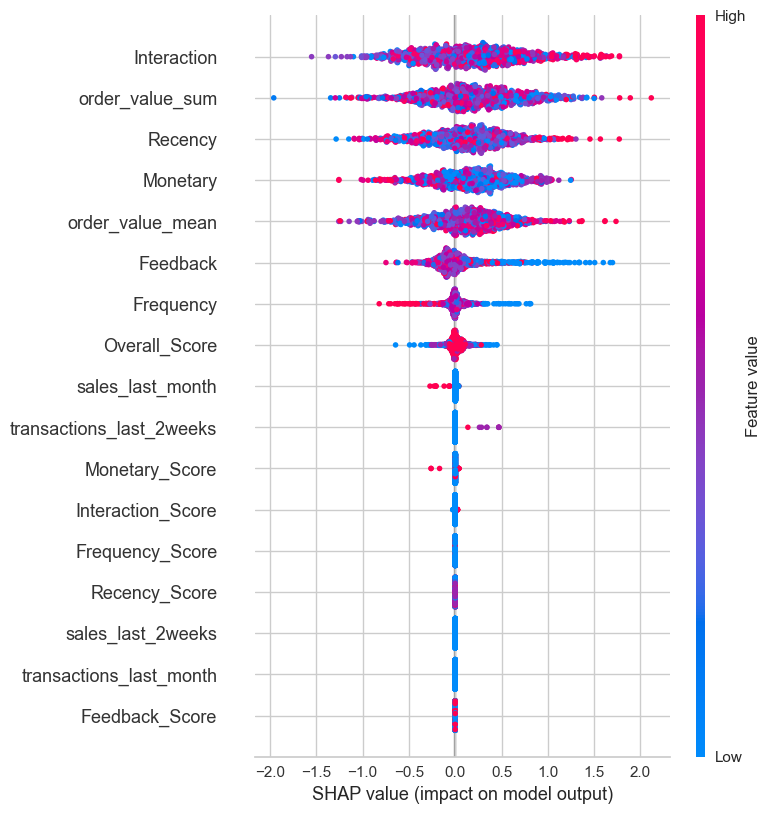

In [572]:
clf.interpret_model(xgb_clf_model)

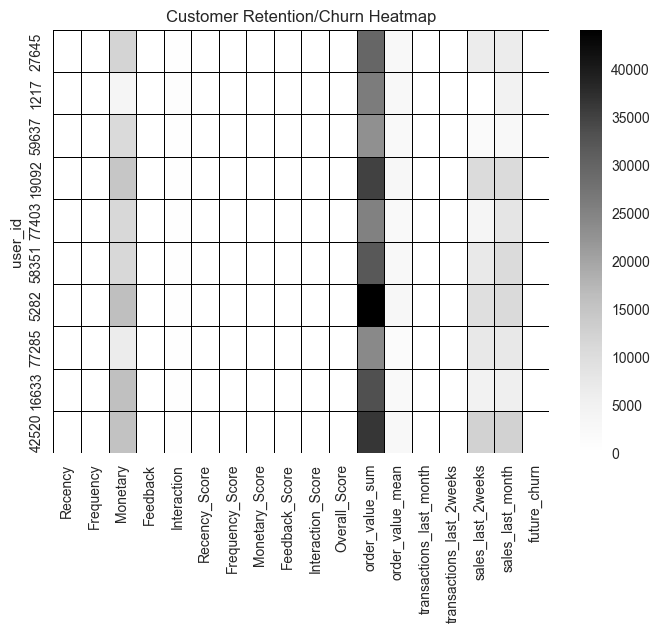

In [676]:
# Create a black and white heatmap
sns.heatmap(clf_predictions_data.sample(10), cmap='Greys', linewidths=0.5, linecolor='black')

# Show plot
plt.title('Customer Retention/Churn Heatmap')
plt.show()



In [421]:
evaluate_model(xgb_clf_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [573]:
# REGRESSION ---------
reg_setup = reg.setup(
            data = l,#.drop('future_churn', axis = 1),
            target = '90_day_future_spend',
            train_size = 0.8,
            normalize = True,
            session_id = 123,
            verbose = True,
            log_experiment = False)
xgb_reg_model = reg.create_model('xgboost')
reg_predictions_data = reg.predict_model(xgb_reg_model, data = l)\
                       .sort_values('prediction_label', ascending = False) 

,Description,Value
0,Session id,123
1,Target,90_day_future_spend
2,Target type,Regression
3,Original data shape,"(5927, 19)"
4,Transformed data shape,"(5927, 19)"
5,Transformed train set shape,"(4741, 19)"
6,Transformed test set shape,"(1186, 19)"
7,Numeric features,18
8,Preprocess,True
9,Imputation type,simple


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3336.7634,17913358.0000,4232.4175,-0.0233,2.0446,2.9202
1,3543.0205,22159494.0000,4707.3872,0.0327,2.1127,1.8896
2,3598.5264,20550518.0000,4533.2681,0.0465,2.1181,2.3705
3,3482.7463,19434760.0000,4408.4873,0.0678,2.3045,1.9798
4,3517.5305,21803332.0000,4669.4038,0.0192,2.1627,2.6883
5,3469.3320,19660062.0000,4433.9668,0.0637,2.2503,2.1954
6,3427.6831,19886868.0000,4459.4692,0.0751,1.9455,1.4934
7,3360.0691,18757736.0000,4331.0200,-0.0237,2.3064,2.0475
8,3821.7754,25310226.0000,5030.9268,0.0041,2.2533,2.0573


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,2021.1178,8004804.5000,2829.2764,0.6198,1.9498,1.5094


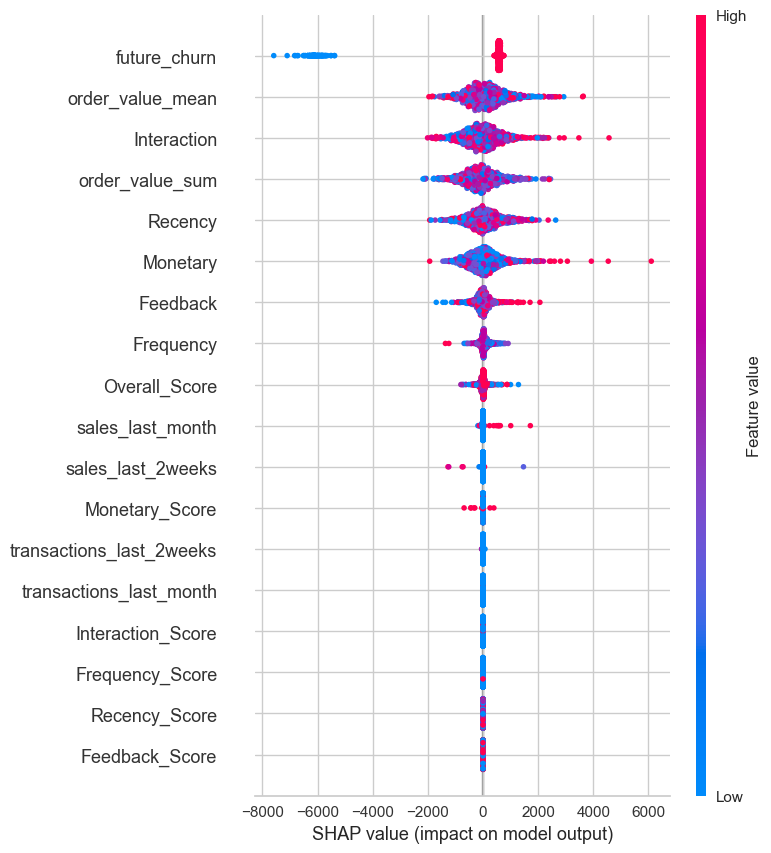

In [574]:
reg.interpret_model(xgb_reg_model)

### Medium-Value Segment Predictions 

In [600]:
m = calculate_feature_data(temporal_in_data, medium_training_data, medium_testing_data)
m

,Recency,Frequency,Monetary,Feedback,Interaction,Recency_Score,Frequency_Score,Monetary_Score,Feedback_Score,Interaction_Score,Overall_Score,order_value_sum,order_value_mean,transactions_last_month,transactions_last_2weeks,sales_last_2weeks,sales_last_month,90_day_future_spend,future_churn
user_id,,,,,,,,,,,,,,,,,,,
3,33,6,4852.62,-1.20,381,2,1,1,1,1,6,12959.40,2159.90,0.00,0.00,0.00,0.00,1388.50,1.00
6,93,4,6930.25,0.00,129,1,0,1,2,0,4,15240.93,3810.23,0.00,0.00,0.00,0.00,1410.57,1.00
8,67,9,7824.39,-1.20,269,1,2,1,1,1,6,24960.46,2773.38,0.00,0.00,0.00,0.00,7158.78,1.00
9,19,5,6768.65,-0.60,261,3,1,1,1,1,7,11797.34,2359.47,1.00,0.00,0.00,2515.38,3192.14,1.00
11,38,5,4720.91,-0.30,189,2,1,1,2,0,6,10420.43,2084.09,0.00,0.00,0.00,0.00,5801.21,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99986,105,6,7770.12,-0.90,198,1,1,1,1,0,4,16794.84,2799.14,0.00,0.00,0.00,0.00,3787.55,1.00
99987,2,4,1193.05,-0.10,271,3,0,0,2,1,6,10975.23,2743.81,1.00,1.00,2798.97,2798.97,6692.95,1.00
99990,140,5,11526.86,-0.30,202,0,1,2,2,0,5,12417.48,2483.50,0.00,0.00,0.00,0.00,0.00,0.00


In [601]:
# CLASSIFICATION (SPEND/CHURN PROBABILITY) -------
clf_setup = clf.setup(
            data = m.drop('90_day_future_spend', axis = 1),
            target = 'future_churn',
            train_size = 0.8,
            session_id = 123,
            verbose = True,
            log_experiment = False)
xgb_clf_model = clf.create_model('xgboost')
clf_predictions_data = clf.predict_model(xgb_clf_model, data = m, raw_score = True)\
                        .sort_values('prediction_score_1', ascending = False)

,Description,Value
0,Session id,123
1,Target,future_churn
2,Target type,Binary
3,Original data shape,"(39657, 18)"
4,Transformed data shape,"(39657, 18)"
5,Transformed train set shape,"(31725, 18)"
6,Transformed test set shape,"(7932, 18)"
7,Numeric features,17
8,Preprocess,True
9,Imputation type,simple


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9155,0.5128,0.9997,0.9158,0.9559,-0.0006,-0.0054
1,0.9143,0.5069,0.9983,0.9157,0.9552,-0.0031,-0.0120
2,0.9146,0.4765,0.9986,0.9157,0.9554,-0.0025,-0.0108
3,0.9155,0.5094,0.9997,0.9158,0.9559,-0.0006,-0.0054
4,0.9146,0.5167,0.9986,0.9157,0.9554,-0.0025,-0.0108
5,0.9155,0.5014,0.9990,0.9164,0.9559,0.0049,0.0213
6,0.9149,0.5250,0.9983,0.9163,0.9555,0.0037,0.0130
7,0.9158,0.4861,0.9997,0.9161,0.9561,-0.0006,-0.0054
8,0.9158,0.5124,0.9997,0.9161,0.9561,-0.0006,-0.0054


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9212,0.8440,0.9998,0.9209,0.9588,0.1112,0.2392


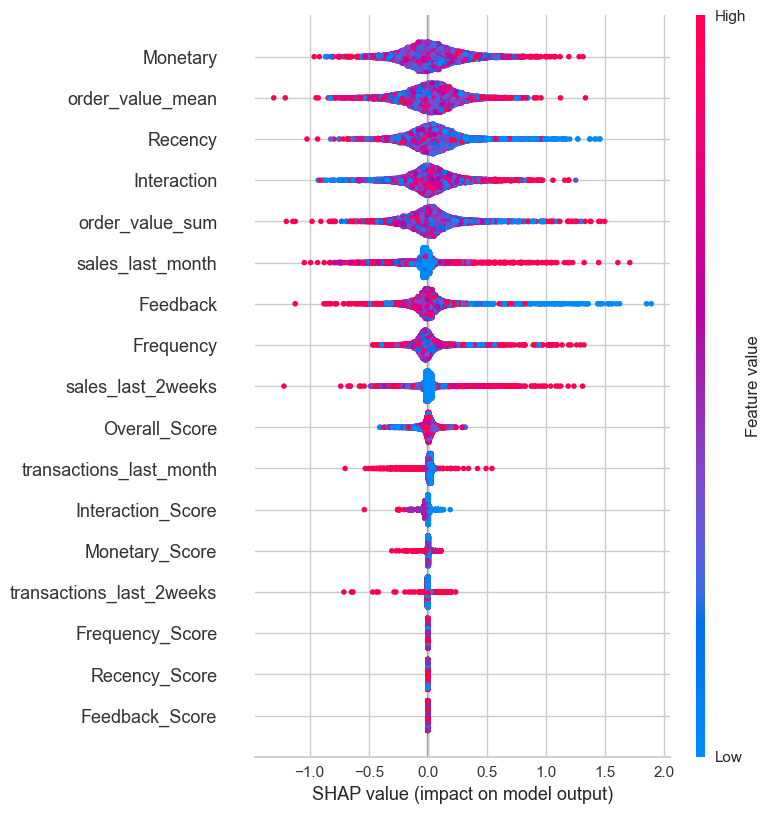

In [602]:
clf.interpret_model(xgb_clf_model)

In [426]:
evaluate_model(xgb_clf_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [603]:
# REGRESSION ---------
reg_setup = reg.setup(
            data = m,#.drop('future_churn', axis = 1),
            target = '90_day_future_spend',
            train_size = 0.8,
            normalize = True,
            session_id = 123,
            verbose = True,
            log_experiment = False)
xgb_reg_model = reg.create_model('xgboost')
reg_predictions_data = reg.predict_model(xgb_reg_model, data = m)\
                       .sort_values('prediction_label', ascending = False) 

,Description,Value
0,Session id,123
1,Target,90_day_future_spend
2,Target type,Regression
3,Original data shape,"(39657, 19)"
4,Transformed data shape,"(39657, 19)"
5,Transformed train set shape,"(31725, 19)"
6,Transformed test set shape,"(7932, 19)"
7,Numeric features,18
8,Preprocess,True
9,Imputation type,simple


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3217.1970,17293214.0000,4158.5112,0.1195,1.9196,1.9963
1,3307.0129,18672692.0000,4321.1909,0.1336,1.9838,9.0939
2,3310.9705,18754344.0000,4330.6284,0.1286,1.9411,2.4224
3,3247.5984,18106928.0000,4255.2236,0.1178,1.9999,2.9885
4,3285.6611,18561378.0000,4308.2920,0.1284,2.0345,2.3791
5,3215.4001,17585984.0000,4193.5645,0.1294,1.9875,2.0820
6,3323.7693,18495594.0000,4300.6504,0.1135,1.8736,3.0404
7,3245.6907,17847040.0000,4224.5757,0.1214,1.9580,3.3309
8,3278.4543,18150642.0000,4260.3569,0.1140,1.9651,30.0083


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,2832.5435,13796496.0000,3714.3635,0.3319,1.8746,5.4680


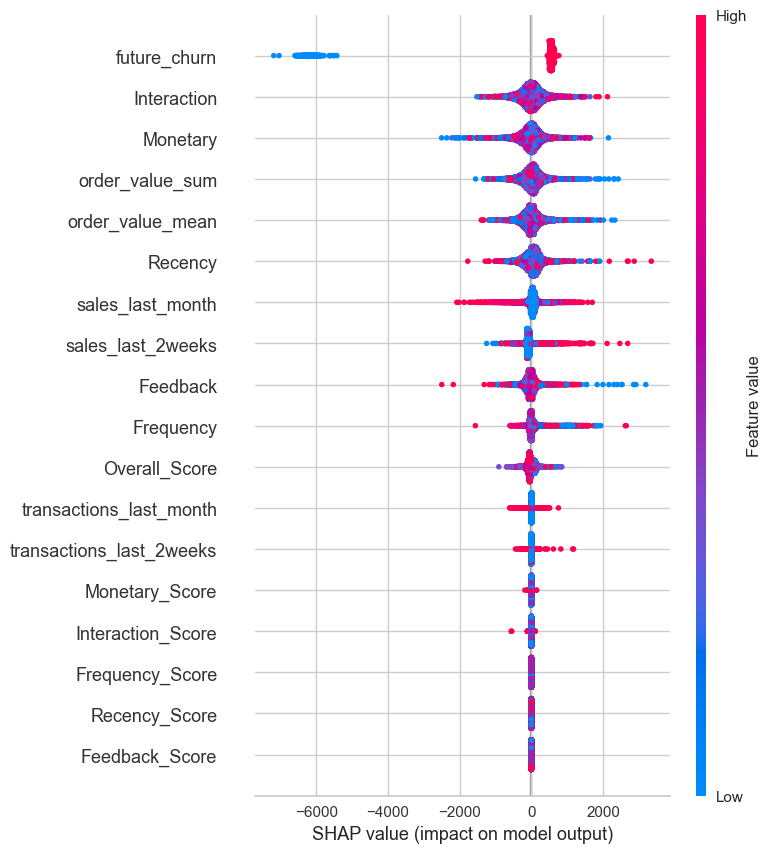

In [604]:
reg.interpret_model(xgb_reg_model)

### High-Value Segment Predictions 

In [626]:
h = calculate_feature_data(temporal_in_data, high_training_data, high_testing_data)
h

,Recency,Frequency,Monetary,Feedback,Interaction,Recency_Score,Frequency_Score,Monetary_Score,Feedback_Score,Interaction_Score,Overall_Score,order_value_sum,order_value_mean,transactions_last_month,transactions_last_2weeks,sales_last_2weeks,sales_last_month,90_day_future_spend,future_churn
user_id,,,,,,,,,,,,,,,,,,,
2,4,10,7088.22,0.20,360,3,3,1,2,1,10,19850.75,1985.08,2.00,1.00,5289.55,5973.49,6034.06,1.00
4,6,12,11694.65,-1.50,733,3,3,2,0,3,11,27967.69,2330.64,1.00,1.00,1585.51,1585.51,5062.14,1.00
10,4,10,5977.11,-0.60,599,3,3,1,1,3,11,19185.07,1918.51,1.00,1.00,9108.87,9108.87,8559.35,1.00
12,36,11,10905.59,-0.90,640,2,3,2,1,3,11,24220.64,2201.88,0.00,0.00,0.00,0.00,9387.89,1.00
16,1,10,13104.91,-2.50,463,3,3,2,0,2,10,25737.07,2573.71,2.00,2.00,3453.91,3453.91,1551.89,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,19,6,11012.95,0.40,341,3,1,2,3,1,10,15452.49,2575.41,1.00,0.00,0.00,3041.66,2241.95,1.00
99996,9,9,9310.30,-0.70,445,3,2,2,1,2,10,23115.49,2568.39,1.00,1.00,825.42,825.42,3200.63,1.00
99998,42,9,8999.69,-1.20,594,2,2,1,1,3,9,19828.30,2203.14,0.00,0.00,0.00,0.00,4174.99,1.00


In [627]:
# CLASSIFICATION (SPEND/CHURN PROBABILITY) -------
clf_setup = clf.setup(
            data = h.drop('90_day_future_spend', axis = 1),
            target = 'future_churn',
            train_size = 0.8,
            session_id = 123,
            verbose = True,
            log_experiment = False)
xgb_clf_model = clf.create_model('xgboost')
clf_predictions_data = clf.predict_model(xgb_clf_model, data = h, raw_score = True)\
                        .sort_values('prediction_score_1', ascending = False)

,Description,Value
0,Session id,123
1,Target,future_churn
2,Target type,Binary
3,Original data shape,"(46010, 18)"
4,Transformed data shape,"(46010, 18)"
5,Transformed train set shape,"(36808, 18)"
6,Transformed test set shape,"(9202, 18)"
7,Numeric features,17
8,Preprocess,True
9,Imputation type,simple


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9177,0.5195,0.9994,0.9182,0.9571,-0.0011,-0.0070
1,0.9182,0.4913,0.9997,0.9185,0.9574,0.0055,0.0356
2,0.9169,0.4887,0.9982,0.9183,0.9566,0.0028,0.0097
3,0.9171,0.4975,0.9988,0.9181,0.9568,-0.0021,-0.0098
4,0.9171,0.4894,0.9988,0.9181,0.9568,-0.0021,-0.0098
5,0.9177,0.5248,0.9994,0.9182,0.9571,0.0050,0.0262
6,0.9171,0.4915,0.9991,0.9179,0.9568,-0.0016,-0.0085
7,0.9180,0.4913,1.0000,0.9180,0.9572,0.0000,0.0000
8,0.9171,0.4995,0.9985,0.9183,0.9568,0.0033,0.0125


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9233,0.8439,0.9998,0.9231,0.9599,0.1131,0.2399


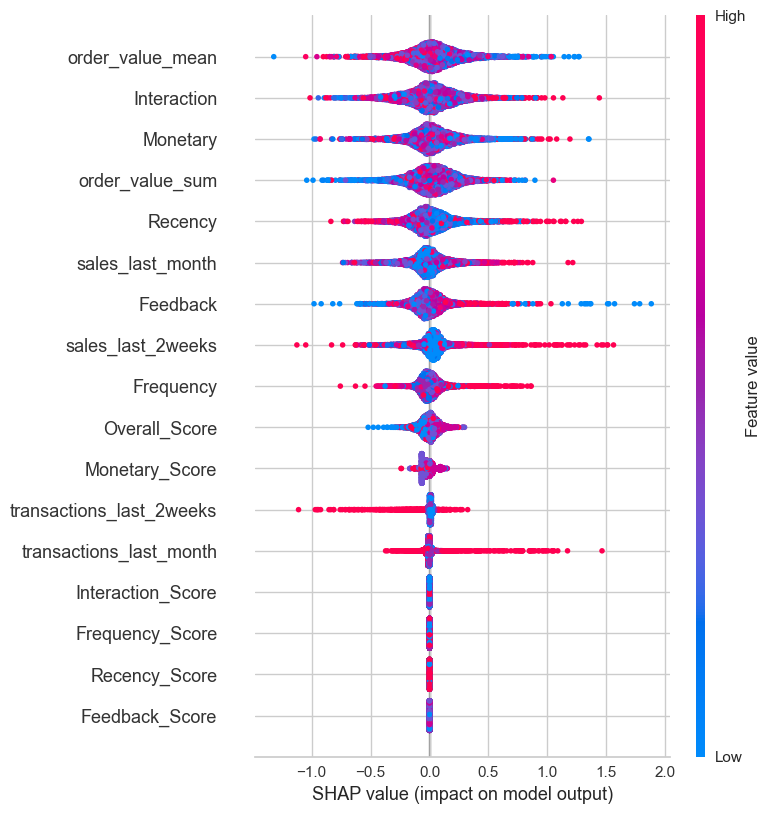

In [628]:
clf.interpret_model(xgb_clf_model)

In [431]:
evaluate_model(xgb_clf_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [629]:
# REGRESSION ---------
reg_setup = reg.setup(
            data = h,#.drop('future_churn', axis = 1),
            target = '90_day_future_spend',
            train_size = 0.8,
            normalize = True,
            session_id = 123,
            verbose = True,
            log_experiment = False)
xgb_reg_model = reg.create_model('xgboost')
reg_predictions_data = reg.predict_model(xgb_reg_model, data = h)\
                       .sort_values('prediction_label', ascending = False) 

,Description,Value
0,Session id,123
1,Target,90_day_future_spend
2,Target type,Regression
3,Original data shape,"(46010, 19)"
4,Transformed data shape,"(46010, 19)"
5,Transformed train set shape,"(36808, 19)"
6,Transformed test set shape,"(9202, 19)"
7,Numeric features,18
8,Preprocess,True
9,Imputation type,simple


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3295.2620,18316988.0000,4279.8350,0.1360,2.0193,4.5279
1,3329.5864,18555202.0000,4307.5752,0.1128,1.9000,2.8907
2,3327.5901,18854056.0000,4342.1260,0.0963,1.8622,4.8380
3,3330.6125,18483638.0000,4299.2603,0.1043,1.9700,10.6911
4,3299.1008,18416208.0000,4291.4111,0.1203,1.9686,3.0709
5,3302.1643,18201020.0000,4266.2651,0.1314,2.0592,2.6506
6,3275.9189,18264578.0000,4273.7075,0.1306,1.9934,3.3748
7,3327.4104,18300394.0000,4277.8960,0.1072,1.8801,3.8080
8,3280.2930,18351740.0000,4283.8931,0.1280,2.0004,2.4304


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,2881.4258,14190782.0000,3767.0657,0.3201,1.8761,3.4784


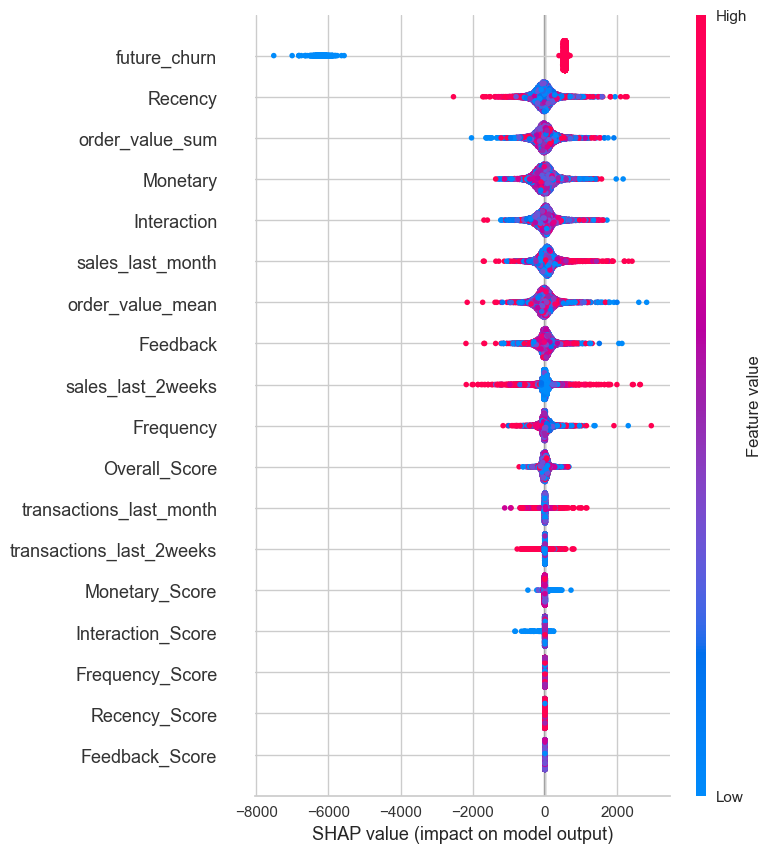

In [630]:
reg.interpret_model(xgb_reg_model)

### Very High Segment 

In [652]:
vh = calculate_feature_data(temporal_in_data, very_high_training_data, very_high_testing_data)
vh

,Recency,Frequency,Monetary,Feedback,Interaction,Recency_Score,Frequency_Score,Monetary_Score,Feedback_Score,Interaction_Score,Overall_Score,order_value_sum,order_value_mean,transactions_last_month,transactions_last_2weeks,sales_last_2weeks,sales_last_month,90_day_future_spend,future_churn
user_id,,,,,,,,,,,,,,,,,,,
1,15,12,15861.73,-0.90,710,3,3,3,1,3,13,32310.06,2692.50,1.00,0.00,0.00,4447.31,4933.51,1.00
7,19,7,11974.13,1.00,415,3,2,2,3,2,12,17664.36,2523.48,1.00,0.00,0.00,4175.28,4865.33,1.00
25,47,11,20591.98,-1.20,614,2,3,3,1,3,12,31590.09,2871.83,0.00,0.00,0.00,0.00,16732.30,1.00
39,28,13,16180.50,0.70,629,3,3,3,3,3,15,41747.36,3211.34,1.00,0.00,0.00,7733.91,4955.38,1.00
44,9,12,21501.19,-0.90,496,3,3,3,1,2,12,31845.21,2653.77,2.00,1.00,4823.21,6656.04,8754.20,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99970,23,11,11620.89,1.00,445,3,3,2,3,2,13,25170.17,2288.20,1.00,0.00,0.00,3071.76,11220.60,1.00
99974,4,10,19157.97,-0.30,400,3,3,3,2,2,13,28043.96,2804.40,2.00,1.00,4528.82,6624.90,3060.08,1.00
99975,2,10,6708.95,0.60,653,3,3,1,3,3,13,33287.57,3328.76,2.00,2.00,8697.15,8697.15,5116.96,1.00


In [653]:
# CLASSIFICATION (SPEND/CHURN PROBABILITY) -------
clf_setup = clf.setup(
            data = vh.drop('90_day_future_spend', axis = 1),
            target = 'future_churn',
            train_size = 0.8,
            session_id = 123,
            verbose = True,
            log_experiment = False)
xgb_clf_model = clf.create_model('xgboost')
clf_predictions_data = clf.predict_model(xgb_clf_model, data = vh, raw_score = True)\
                        .sort_values('prediction_score_1', ascending = False)

,Description,Value
0,Session id,123
1,Target,future_churn
2,Target type,Binary
3,Original data shape,"(8333, 18)"
4,Transformed data shape,"(8333, 18)"
5,Transformed train set shape,"(6666, 18)"
6,Transformed test set shape,"(1667, 18)"
7,Numeric features,17
8,Preprocess,True
9,Imputation type,simple


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9175,0.4827,0.9967,0.9203,0.9570,-0.0058,-0.0161
1,0.9130,0.4304,0.9919,0.9199,0.9545,-0.0139,-0.0255
2,0.9145,0.4980,0.9935,0.9201,0.9554,-0.0113,-0.0228
3,0.9175,0.4794,0.9967,0.9203,0.9570,-0.0058,-0.0161
4,0.9175,0.5387,0.9951,0.9216,0.9569,0.0242,0.0490
5,0.9190,0.4900,0.9984,0.9204,0.9578,-0.0030,-0.0114
6,0.9159,0.4972,0.9935,0.9215,0.9561,-0.0113,-0.0226
7,0.9144,0.5925,0.9935,0.9199,0.9553,-0.0113,-0.0229
8,0.9159,0.5113,0.9951,0.9201,0.9561,-0.0086,-0.0198


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9707,0.9088,0.9995,0.9697,0.9843,0.7604,0.7817


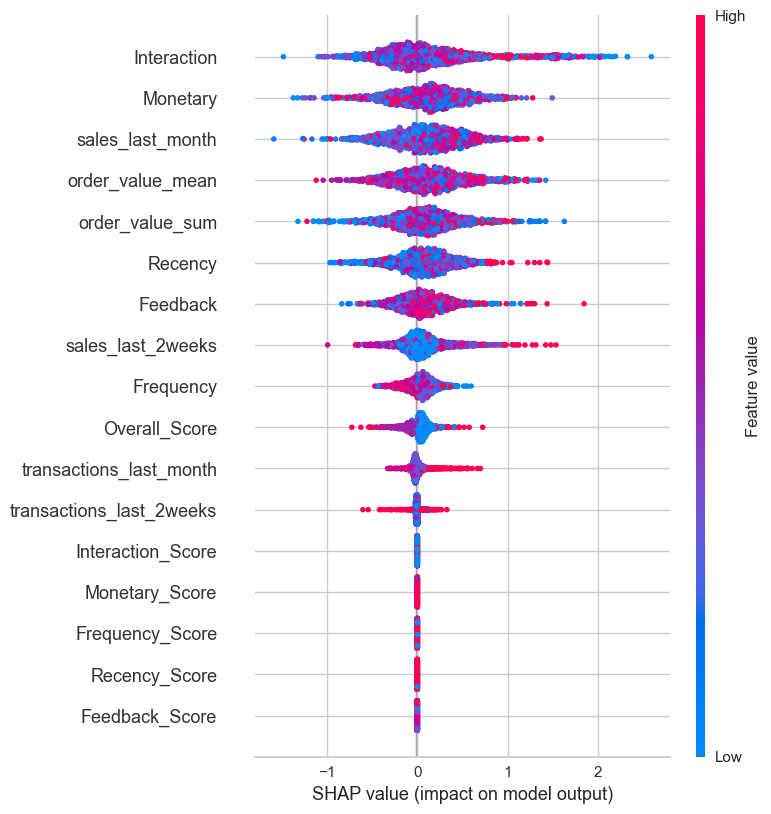

In [654]:
clf.interpret_model(xgb_clf_model)

In [655]:
# REGRESSION ---------
reg_setup = reg.setup(
            data = vh,#.drop('future_churn', axis = 1),
            target = '90_day_future_spend',
            train_size = 0.8,
            normalize = True,
            session_id = 123,
            verbose = True,
            log_experiment = False)
xgb_reg_model = reg.create_model('xgboost')
reg_predictions_data = reg.predict_model(xgb_reg_model, data = vh)\
                       .sort_values('prediction_label', ascending = False) 

,Description,Value
0,Session id,123
1,Target,90_day_future_spend
2,Target type,Regression
3,Original data shape,"(8333, 19)"
4,Transformed data shape,"(8333, 19)"
5,Transformed train set shape,"(6666, 19)"
6,Transformed test set shape,"(1667, 19)"
7,Numeric features,18
8,Preprocess,True
9,Imputation type,simple


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3472.2512,19854524.0000,4455.8418,0.0177,2.1514,2.1149
1,3328.9124,17933136.0000,4234.7534,0.0182,2.1435,6.6076
2,3373.7939,19054966.0000,4365.1992,-0.0091,1.8784,1.6416
3,3427.9250,19042190.0000,4363.7358,0.0527,2.1445,36.3921
4,3583.5706,21228246.0000,4607.4121,0.0159,2.0882,9.4364
5,3390.0105,18547218.0000,4306.6479,0.0500,1.9741,2.1387
6,3489.0000,20225968.0000,4497.3291,0.0142,2.1886,1.7488
7,3472.5398,20372616.0000,4513.6035,0.0813,2.3233,2.3790
8,3698.5852,21586882.0000,4646.1685,-0.0579,1.9661,12.2754


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,2024.6761,7567198.0000,2750.8540,0.6163,1.8869,3.7947


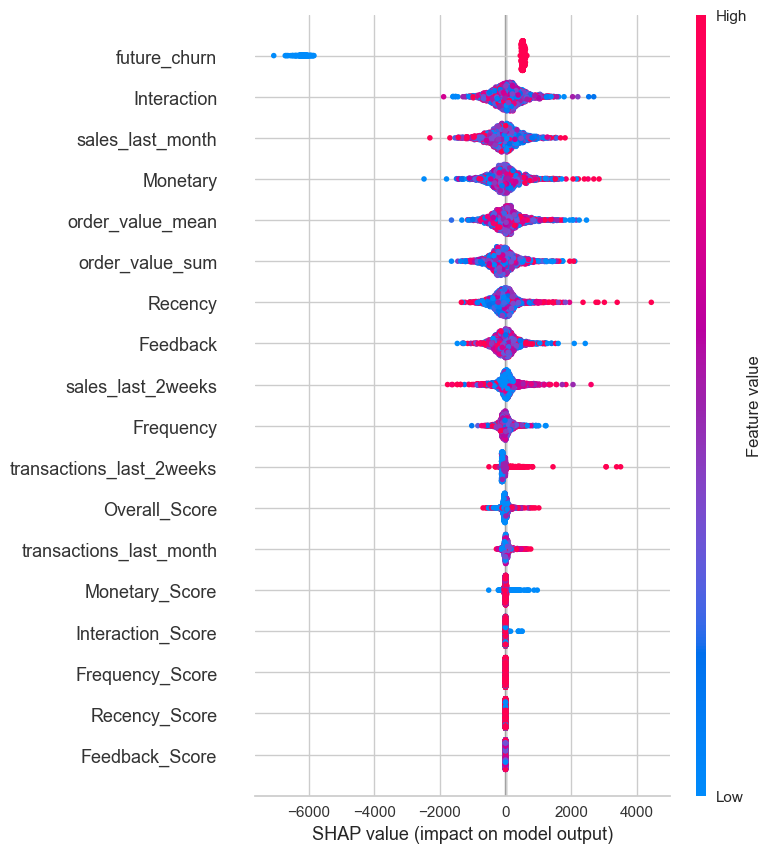

In [656]:
reg.interpret_model(xgb_reg_model)

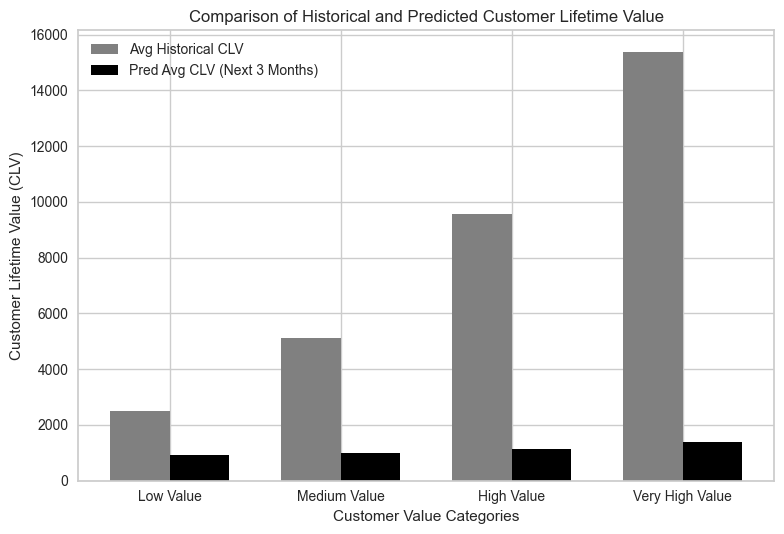

In [662]:
# Data
categories = ['Low Value', 'Medium Value', 'High Value', 'Very High Value']
avg_historical_clv = [2503.3933, 5102.775, 9572.703, 15378.916]
pred_avg_clv = [908.5781, 991.9751, 1140.8077, 1400.1859]

# Bar width
bar_width = 0.35

# Create an array of indices for the x-axis
indices = np.arange(len(categories))

# Create the bar plots
plt.bar(indices, avg_historical_clv, width=bar_width, label='Avg Historical CLV', color='grey')
plt.bar(indices + bar_width, pred_avg_clv, width=bar_width, label='Pred Avg CLV (Next 3 Months)', color='black')

# Add labels and title
plt.xlabel('Customer Value Categories')
plt.ylabel('Customer Lifetime Value (CLV)')
plt.title('Comparison of Historical and Predicted Customer Lifetime Value')
plt.xticks(indices + bar_width / 2, categories)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


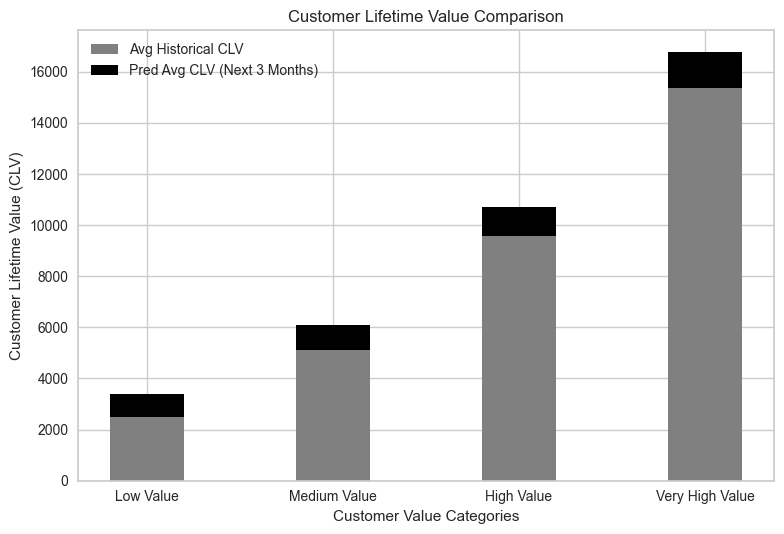

In [664]:
# Data
categories = ['Low Value', 'Medium Value', 'High Value', 'Very High Value']
avg_historical_clv = [2503.3933, 5102.775, 9572.703, 15378.916]
pred_avg_clv_next_3_months = [908.5781, 991.9751, 1140.8077, 1400.1859]

# Creating a stacked bar graph
bar_width = 0.4
x = np.arange(len(categories))

# Plotting the bars
plt.bar(x, avg_historical_clv, width=bar_width, label='Avg Historical CLV', color='grey')
plt.bar(x, pred_avg_clv_next_3_months, width=bar_width, bottom=avg_historical_clv, label='Pred Avg CLV (Next 3 Months)', color='black')

# Adding labels and title
plt.xlabel('Customer Value Categories')
plt.ylabel('Customer Lifetime Value (CLV)')
plt.title('Customer Lifetime Value Comparison')
plt.xticks(x, categories)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


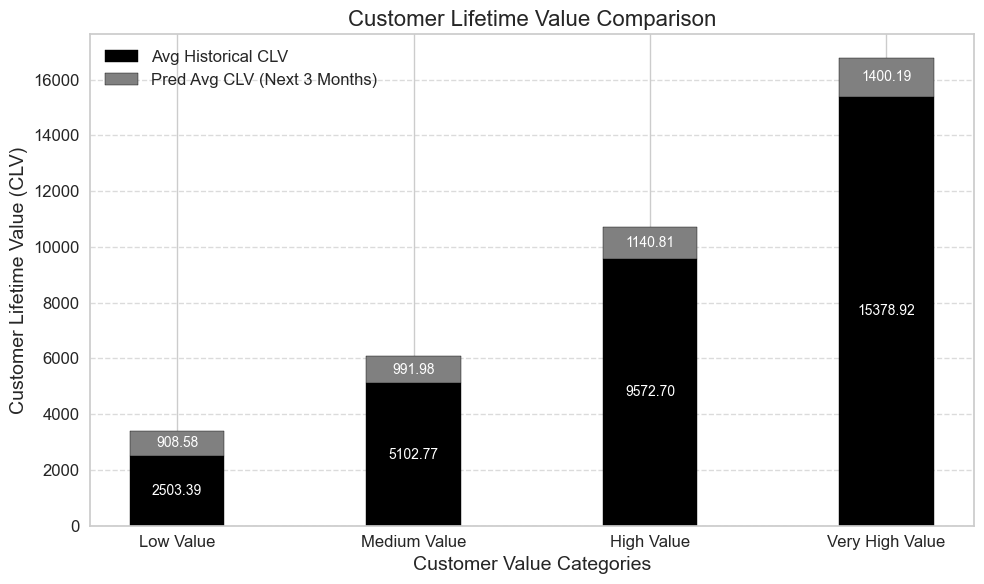

In [669]:

# Data
categories = ['Low Value', 'Medium Value', 'High Value', 'Very High Value']
avg_historical_clv = [2503.3933, 5102.775, 9572.703, 15378.916]
pred_avg_clv_next_3_months = [908.5781, 991.9751, 1140.8077, 1400.1859]

# Creating a stacked bar graph
bar_width = 0.4
x = np.arange(len(categories))

# Setting up the figure and axes
plt.figure(figsize=(10, 6))
plt.bar(x, avg_historical_clv, width=bar_width, label='Avg Historical CLV', color='black', edgecolor='black')
plt.bar(x, pred_avg_clv_next_3_months, width=bar_width, bottom=avg_historical_clv, label='Pred Avg CLV (Next 3 Months)', color='grey', edgecolor='black')

# Adding data labels
for i in range(len(categories)):
    plt.text(x[i], avg_historical_clv[i] / 2, f'{avg_historical_clv[i]:.2f}', ha='center', va='center', color='white', fontsize=10)
    plt.text(x[i], avg_historical_clv[i] + pred_avg_clv_next_3_months[i] / 2, f'{pred_avg_clv_next_3_months[i]:.2f}', ha='center', va='center', color='white', fontsize=10)

# Adding labels and title
plt.xlabel('Customer Value Categories', fontsize=14)
plt.ylabel('Customer Lifetime Value (CLV)', fontsize=14)
plt.title('Customer Lifetime Value Comparison', fontsize=16)
plt.xticks(x, categories, fontsize=12)
plt.yticks(fontsize=12)

# Adding grid and legend
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


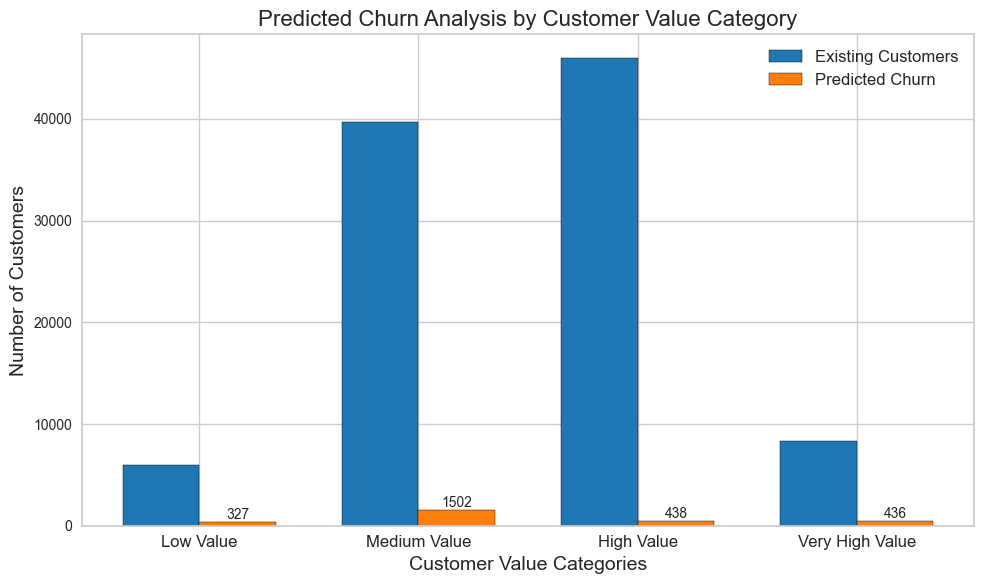

In [670]:

# Data
categories = ['Low Value', 'Medium Value', 'High Value', 'Very High Value']
existing_customers = [5927, 39657, 46010, 8333]
predicted_churn = [327, 1502, 438, 436]

# Calculate churn rates
churn_rates = [churn / total * 100 for churn, total in zip(predicted_churn, existing_customers)]

# Create figure and axes
bar_width = 0.35
x = np.arange(len(categories))

plt.figure(figsize=(10, 6))

# Plot existing customers and predicted churn
plt.bar(x - bar_width/2, existing_customers, width=bar_width, label='Existing Customers', color='#1f77b4', edgecolor='black')
plt.bar(x + bar_width/2, predicted_churn, width=bar_width, label='Predicted Churn', color='#ff7f0e', edgecolor='black')

# Adding data labels for predicted churn
for i in range(len(categories)):
    plt.text(x[i] + bar_width/2, predicted_churn[i] + 20, f'{predicted_churn[i]}', ha='center', va='bottom', fontsize=10)

# Adding labels and title
plt.xlabel('Customer Value Categories', fontsize=14)
plt.ylabel('Number of Customers', fontsize=14)
plt.title('Predicted Churn Analysis by Customer Value Category', fontsize=16)
plt.xticks(x, categories, fontsize=12)
plt.legend(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


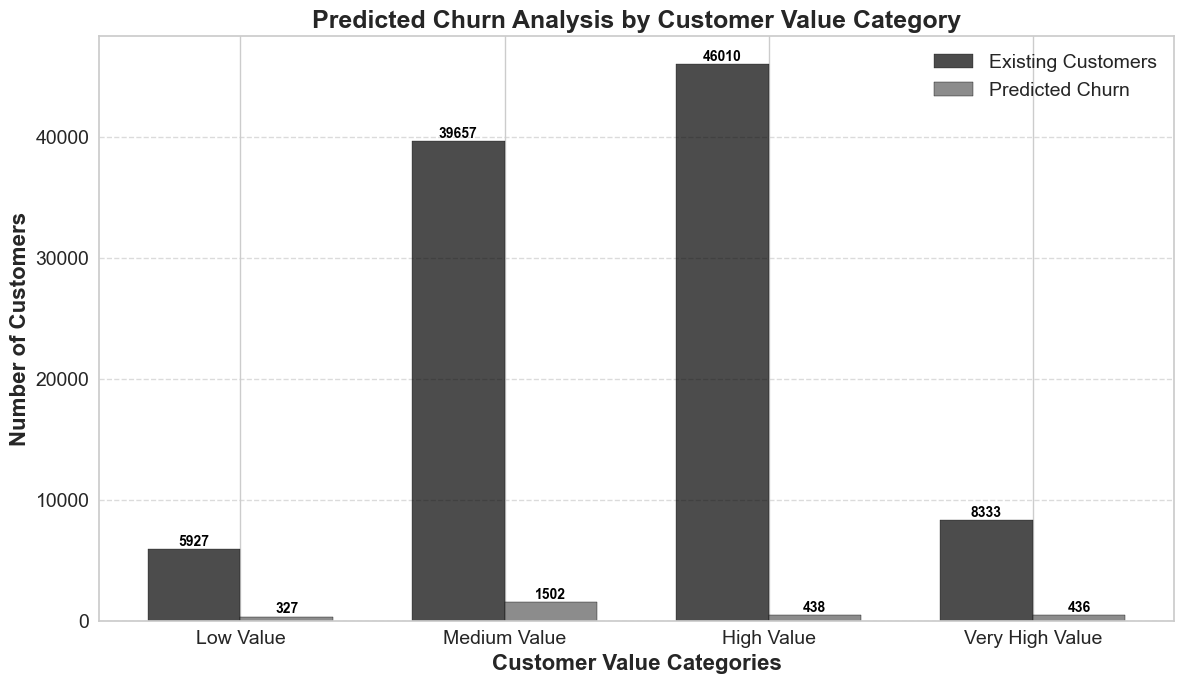

In [673]:

# Data
categories = ['Low Value', 'Medium Value', 'High Value', 'Very High Value']
existing_customers = [5927, 39657, 46010, 8333]
predicted_churn = [327, 1502, 438, 436]

# Create figure and axes
bar_width = 0.35
x = np.arange(len(categories))

plt.figure(figsize=(12, 7))

# Plot existing customers and predicted churn with improved aesthetics
bars1 = plt.bar(x - bar_width/2, existing_customers, width=bar_width, label='Existing Customers', 
                color='black', edgecolor='black', alpha=0.7)
bars2 = plt.bar(x + bar_width/2, predicted_churn, width=bar_width, label='Predicted Churn', 
                color='grey', edgecolor='black', alpha=0.9)

# Adding data labels for predicted churn
for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 20, f'{yval}', ha='center', va='bottom', 
             fontsize=10, fontweight='bold', color='black')

# Adding data labels for existing customers
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 20, f'{yval}', ha='center', va='bottom', 
             fontsize=10, fontweight='bold', color='black')

# Adding labels and title
plt.xlabel('Customer Value Categories', fontsize=16, fontweight='bold')
plt.ylabel('Number of Customers', fontsize=16, fontweight='bold')
plt.title('Predicted Churn Analysis by Customer Value Category', fontsize=18, fontweight='bold')
plt.xticks(x, categories, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)

# Adding grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()
